<a href="https://colab.research.google.com/github/mgozon/DLG-UROP/blob/main/Batch_DLG_Evolution_BRAZPD_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Batch-DLG Evolution - BRAZPD Dataset
This notebook is based on the [Batch-DLG Evolution - Iris Dataset](https://github.com/mgozon/DLG-UROP/blob/main/Batch_DLG_Evolution_Iris_Dataset.ipynb), which implements the procedure in [Deep Leakage from Gradients](https://gist.github.com/Lyken17/91b81526a8245a028d4f85ccc9191884) on the IRIS Dataset. In particular, a fully connected nueral network is trained using mini-batch gradients which are leaked. We now modify the code to run on the BRAZPD dataset.

# Setting up Libaries and Utilities

In [ ]:
# setting up machine learning/visualization libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
#torch.manual_seed(100) # for generating the same random weights
from torch.utils.data import RandomSampler
from torch.utils.data import random_split
from sklearn.preprocessing import StandardScaler
import random

# setting up optimal device
print(torch.__version__)
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

2.0.0+cu118
Running on cpu


In [ ]:
#@title Adding dlg_stats and dlg_models
from google.colab import drive
drive.mount('/content/drive/')
%run 'drive/MyDrive/UROP/Project Files/dlg_models.ipynb'
!cp 'drive/MyDrive/UROP/Project Files/BRAZPD_UnofM_all.csv' 'BRAZPD_UnofM_all.csv'
drive.flush_and_unmount()

Mounted at /content/drive/
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
defined: assign_guess(guess, gt_dataset, n, verbose = False): guess_perm
defined: assign_best(guess, gt_dataset, n, verbose = False): best_match
defined: compute_stats(guess_perm, gt_data, recovered_threshold = 0.25): rel_errors, recovered_rate, cos_angles
defined: batch_DLG_Adam(net, criterion, device, original_dy_dx, batch_size, gt_data_len, gt_onehot_label_len, epoch_mult = 500, w_decay = 1e-12, scheduler_k = 0.001, verbose = False): dummy_data, losses
defined: label_to_onehot(target, n_classes): onehot_target
defined: train_net_Adam(net, criterion, device, train_data, train_target, output_dim, batch_size = 32, epochs = 100): losses
defined: test_net(net, test_data, test_target): prints accuracy
defined: train_net_Adam_DLG(net, criterion, device, scaler, train_data, train_target, output_dim, batch_size = 32, epochs = 100, verbo

# Preprocess BRAZPD Dataset

In [ ]:
# import BRAZPD dataset
import pandas as pd
import numpy as np
import os

filename = 'BRAZPD_UnofM_all.csv'
df = pd.read_csv(filename, engine='python', encoding = "ISO-8859-1")
print(df.shape)
df['followup1yfull'] = df['Followup'].apply(lambda x: 1 if x >= 12 else 0)

(5707, 1735)


In [ ]:
print(df.columns)
print(df['Deathevent'])

Index(['CODPAX', 'Hemoglobin', 'Potassium', 'Phosphate', 'Mean_PAS_1T',
       'Mean_PAD_1T', 'Mean_PAS_2T', 'Mean_PAD_2T', 'Mean_PAS_3T',
       'Mean_PAD_3T',
       ...
       'Systolic71', 'Diastolic71', 'Systolic72', 'Diastolic72', 'Systolic73',
       'Diastolic73', 'Systolic74', 'Diastolic74', '_merge', 'followup1yfull'],
      dtype='object', length=1736)
0       1
1       0
2       0
3       1
4       1
       ..
5702    0
5703    0
5704    0
5705    0
5706    0
Name: Deathevent, Length: 5707, dtype: int64


In [ ]:
# grab baseline features and target
baseline_set = ['CenterSizenpatients', 'Age', 'IncidentinPD', 'PrevalentinPDNet', \
                'Primaryrenaldisease', 'PreviousHD',\
                'Previoustx', 'DaviesScore', 'Peripheralarterydisease',\
                'Cancer', 'Stroke','Hypertension', 'HIV', 'HCV', 'HBC', 'Gender', 'Race',\
                'Familyincome', 'predialysiscare',\
                'timeofpredialysiscare', 'Educationdic4y', 'Region',\
                'Centerexperiencepatientyear', 'BMI', 'Distancefromcenter']
baseline_set_numerical = ['CenterSizenpatients', 'Age', 'Primaryrenaldisease', 'DaviesScore',\
                          'Familyincome', 'timeofpredialysiscare', 'Centerexperiencepatientyear',\
                          'BMI', 'Distancefromcenter']
baseline_set_categorical = ['IncidentinPD', 'PrevalentinPDNet', 'PreviousHD', 'Previoustx', \
                            'Peripheralarterydisease', 'Cancer', 'Stroke', 'Hypertension', \
                            'HIV', 'HCV', 'HBC', 'Gender', 'Race', 'predialysiscare', \
                            'Educationdic4y', 'Region']
# NOTE: BMI, Familyincome, and Distancefromcenter are in the numerical set but
# they are given as categories (not known whether ordered); possibly other variables too

In [ ]:
# def data_to_onehot(baseline_set):
#     res = torch.zeros(df[baseline_set].shape[0], 0)
#     for name in baseline_set:
#         maxval = max(df[name])
#         print(df[name].to_numpy())
#         cnt = maxval+1
#         onehot_data = torch.zeros(res.shape[0], cnt)
#         #onehot_data.scatter_(df[name]).scatter_(1, df[], 1)
#
# data_to_onehot(baseline_set)

# def encode_and_bind(original_dataframe, feature_to_encode):
#     #dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
#     print(pd.get_dummies(df[baseline_set]))
#     res = pd.concat([original_dataframe, dummies], axis=1)
#     return(res)

# encode_and_bind(df, baseline_set[2])

print(pd.concat([pd.get_dummies(df[name], dummy_na=True) for name in baseline_set], axis=1))

      6.0   10.0  11.0  12.0  13.0  16.0  18.0  19.0  20.0  21.0  ...  48.1  \
0        0     0     0     0     0     0     0     0     0     0  ...     0   
1        0     0     0     0     0     0     0     0     0     0  ...     0   
2        0     0     0     0     0     0     0     0     0     0  ...     0   
3        0     0     0     0     0     0     0     0     0     0  ...     0   
4        0     0     0     0     0     0     0     0     0     0  ...     0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
5702     0     0     0     0     0     0     0     0     0     0  ...     0   
5703     0     0     0     0     0     0     0     0     0     0  ...     0   
5704     0     0     0     0     0     0     0     0     0     0  ...     0   
5705     0     0     0     0     0     0     0     0     0     0  ...     0   
5706     0     0     0     0     0     0     0     0     0     0  ...     0   

      49.9  52.6  NaN   1.0   2.0   3.0   4.0   5.0

In [ ]:
# *** load categorical ***
def load_categorical(inp_cnt, target = 'followup1yfull'):
    baseline_set = np.array(baseline_set_categorical)
    assert inp_cnt <= len(baseline_set)
    idxs = list(RandomSampler(baseline_set, num_samples=inp_cnt))
    idxs.sort()
    idxs = np.array(idxs)
    
    # print(baseline_set)
    # print(baseline_set[idxs])
    baseline_set = baseline_set[idxs]

    targets = [target] # ["death_event_1y"]

    X_baseline = pd.concat([pd.get_dummies(df[name], dummy_na=True) for name in baseline_set], axis=1).copy(); X_baseline = X_baseline.to_numpy() # X_baseline.fillna(0, inplace=True);
    Y_baseline = df[targets].copy(); Y_baseline.fillna(Y_baseline.mean(), inplace=True); Y_baseline = Y_baseline.to_numpy()

    print('categorical variables:', baseline_set)
    print(X_baseline)
    print(Y_baseline)

    return X_baseline, Y_baseline

load_categorical(inp_cnt=16)

categorical variables: ['IncidentinPD' 'PrevalentinPDNet' 'PreviousHD' 'Previoustx'
 'Peripheralarterydisease' 'Cancer' 'Stroke' 'Hypertension' 'HIV' 'HCV'
 'HBC' 'Gender' 'Race' 'predialysiscare' 'Educationdic4y' 'Region']
[[1 0 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 ...
 [1 0 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]]
[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]


(array([[1, 0, 1, ..., 0, 0, 0],
        [1, 0, 1, ..., 0, 0, 0],
        [1, 0, 1, ..., 0, 0, 0],
        ...,
        [1, 0, 1, ..., 0, 0, 0],
        [1, 0, 1, ..., 0, 0, 0],
        [1, 0, 1, ..., 0, 0, 0]], dtype=uint8),
 array([[0],
        [1],
        [0],
        ...,
        [0],
        [0],
        [0]]))

In [ ]:
# *** load numerical ***
def load_numerical(inp_cnt = 9, target = 'followup1yfull'):

    baseline_set = np.array(baseline_set_numerical)
    assert inp_cnt <= len(baseline_set)
    idxs = list(RandomSampler(baseline_set, num_samples=inp_cnt))
    idxs.sort()
    idxs = np.array(idxs)
    
    # print(baseline_set)
    # print(baseline_set[idxs])
    baseline_set = baseline_set[idxs]

    targets = [target] # ["death_event_1y"]

    X_baseline = df[baseline_set].copy(); X_baseline.fillna(X_baseline.mean(), inplace=True); X_baseline = X_baseline.to_numpy()
    Y_baseline = df[targets].copy(); Y_baseline.fillna(Y_baseline.mean(), inplace=True); Y_baseline = Y_baseline.to_numpy()

    print('numerical variables:', baseline_set)
    print(X_baseline)
    print(Y_baseline)

    return X_baseline, Y_baseline

X_baseline, Y_baseline = load_numerical(9)

numerical variables: ['CenterSizenpatients' 'Age' 'Primaryrenaldisease' 'DaviesScore'
 'Familyincome' 'timeofpredialysiscare' 'Centerexperiencepatientyear'
 'BMI' 'Distancefromcenter']
[[128.        71.2       81.       ...  30.763889  20.7        1.      ]
 [128.        23.3        0.       ...  30.763889  28.3        1.      ]
 [128.        49.2       81.       ...  30.763889  31.5        1.      ]
 ...
 [ 66.        84.        50.       ...  16.416667  23.5        1.      ]
 [ 66.        54.2       50.       ...  16.416667  35.         1.      ]
 [ 66.        77.8       81.       ...  16.416667  20.6        3.      ]]
[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]


In [ ]:
# rescale BRAZPD dataset
def rescale_data(X_baseline, Y_baseline):
    dst_length = X_baseline.shape[0]
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(X_baseline)
    print(scaled_data)

    torch.manual_seed(100)  # fix a given set of patients
    train_indices, test_indices = random_split(range(dst_length), [int(dst_length*4/5), dst_length - int(dst_length*4/5)])
    train_indices = train_indices.indices
    test_indices = test_indices.indices
    train_data = scaled_data[train_indices]; train_target = Y_baseline[train_indices]
    test_data = scaled_data[test_indices]; test_target = Y_baseline[test_indices]

    input_dim = X_baseline.shape[1]
    output_dim = 2
    print('dimensions: ', input_dim, output_dim)

    return train_data, train_target, test_data, test_target, input_dim, output_dim, scaler

train_data, train_target, test_data, test_target, input_dim, output_dim, scaler = rescale_data(X_baseline, Y_baseline)

[[-0.35269546  0.73954953  0.68738219 ... -0.43880709 -0.86670574
  -0.70452708]
 [-0.35269546 -2.26347891 -1.44938318 ... -0.43880709  0.78158174
  -0.70452708]
 [-0.35269546 -0.63971197  0.68738219 ... -0.43880709  1.47559752
  -0.70452708]
 ...
 [-0.91496972  1.54202894 -0.13039221 ... -1.01264725 -0.25944193
  -0.70452708]
 [-0.91496972 -0.32624345 -0.13039221 ... -1.01264725  2.23467729
  -0.70452708]
 [-0.91496972  1.15332797  0.68738219 ... -1.01264725 -0.88839374
   1.0935143 ]]
dimensions:  9 2


# Setting up Fully Connected Neural Network

In [ ]:
# ***not equivalent to nn.CrossEntropyLoss(), which combines both nn.LogSoftmax() and nn.NLLLoss()
def cross_entropy_for_onehot(pred, onehot_target):
   return torch.mean(torch.sum(- onehot_target * torch.log(pred), 1))

In [ ]:
# a fully connected neural network with random weights and biases
class FcNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FcNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Linear(input_dim, 100),
            act(),
            nn.Linear(100, 100),
            act(),
            nn.Linear(100, 100),
            act(),
            nn.Linear(100, output_dim),
            nn.Softmax(dim=1),
        )
        
    def forward(self, x):
        out = self.body(x)
        return out

def weights_init(m):
    if hasattr(m, "weight"):
        nn.init.xavier_normal_(m.weight.data)
    if hasattr(m, "bias"):
        nn.init.normal_(m.bias.data)

# instantiation
net = FcNet(input_dim, output_dim).to(device)
net.apply(weights_init)
criterion = cross_entropy_for_onehot

In [ ]:
# setup new FCnet on a subset of the baseline numerical features
def setup_net(inp_cnt_num, inp_cnt_cat, target='Deathevent'):
    X_baseline_num, Y_baseline_num = load_numerical(inp_cnt_num, target)
    X_baseline_cat, Y_baseline_cat = load_categorical(inp_cnt_cat, target)
    print(type(X_baseline_num), type(X_baseline_cat))
    X_baseline = np.hstack((X_baseline_num, X_baseline_cat))
    Y_baseline = Y_baseline_num

    train_data, train_target, test_data, test_target, input_dim, output_dim, scaler = rescale_data(X_baseline, Y_baseline)
    net = FcNet(input_dim, output_dim).to(device)
    net.apply(weights_init)
    return net, train_data, train_target, test_data, test_target, input_dim, output_dim, scaler

net, train_data, train_target, test_data, test_target, input_dim, output_dim, scaler = setup_net(inp_cnt_num = 9, inp_cnt_cat = 16)

numerical variables: ['CenterSizenpatients' 'Age' 'Primaryrenaldisease' 'DaviesScore'
 'Familyincome' 'timeofpredialysiscare' 'Centerexperiencepatientyear'
 'BMI' 'Distancefromcenter']
[[128.        71.2       81.       ...  30.763889  20.7        1.      ]
 [128.        23.3        0.       ...  30.763889  28.3        1.      ]
 [128.        49.2       81.       ...  30.763889  31.5        1.      ]
 ...
 [ 66.        84.        50.       ...  16.416667  23.5        1.      ]
 [ 66.        54.2       50.       ...  16.416667  35.         1.      ]
 [ 66.        77.8       81.       ...  16.416667  20.6        3.      ]]
[[1]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
categorical variables: ['IncidentinPD' 'PrevalentinPDNet' 'PreviousHD' 'Previoustx'
 'Peripheralarterydisease' 'Cancer' 'Stroke' 'Hypertension' 'HIV' 'HCV'
 'HBC' 'Gender' 'Race' 'predialysiscare' 'Educationdic4y' 'Region']
[[1 0 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 ...
 [1 0 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 0 1 ...

# Train Model Normally

score: 938/1142


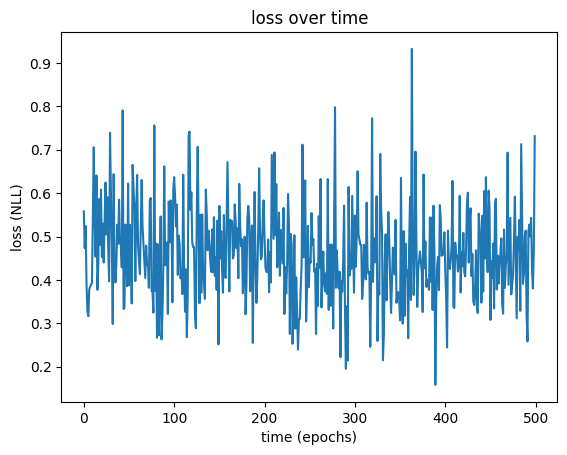

In [ ]:
# note that parameters batch_size and epochs are tuned to yield a more accurate model
net.apply(weights_init)
batch_size = 32 # this affects the smoothness of the loss graph
epochs = 500
losses = train_net_Adam(net, criterion, device, train_data, train_target, output_dim, batch_size, epochs)
test_net(net, test_data, test_target)

plt.plot(list(range(epochs)), losses)
plt.title('loss over time')
plt.xlabel('time (epochs)')
plt.ylabel('loss (NLL)')
plt.show()

# Testing Single Batch DLG (not updated)

In [ ]:
#@title get batch gradient (not updated)
# process specific batch gradient of flowers
def batch_grad(flower_indices):
    n = len(flower_indices)
    # flower_indices = torch.tensor(flower_indices)

    gt_data = torch.tensor(dst.data[flower_indices]).to(device)
    gt_label = torch.tensor(dst.target[flower_indices]).to(device); gt_label = torch.unsqueeze(gt_label, dim=1)
    gt_onehot_label = label_to_onehot(gt_label, n_classes=output_dim)

    out = net(gt_data.float())
    loss = criterion(out, gt_onehot_label)
    batch_dy_dx = torch.autograd.grad(loss, net.parameters())
    original_dy_dx = list((_.detach().clone() for _ in batch_dy_dx)) # share the gradients with other clients
    
    return original_dy_dx, gt_data, gt_label

In [ ]:
#@title run batch_DLG on one batch (not updated)
# testing batch-DLG with Adam
net.apply(weights_init) # see how much easier it is to attack
batch_size = 16
flower_indices = list(RandomSampler(range(dst.data.shape[0]), num_samples=batch_size))
print(flower_indices)
batch_dy_dx, gt_data, gt_label = batch_grad(flower_indices)

dummy_data, losses = batch_DLG_Adam(net, criterion, device, batch_dy_dx, batch_size, gt_data_len = 4, gt_onehot_label_len = 3, epoch_mult = 500, w_decay = 1e-12, scheduler_k = 0.01, verbose = False)
guess_perm = assign_guess(dummy_data, gt_data, batch_size, verbose = True)       # assign all
assign_best(dummy_data, gt_data, batch_size, verbose = True)                     # closest match

plt.plot(torch.log(torch.tensor(losses)))
plt.title('DLG loss over time (---)')
plt.xlabel('time (epochs)')
plt.ylabel('loss (log SE)')
plt.savefig('dlg8-.png', dpi=300)

# DLG Effectiveness on Different Number of Inputs

In [ ]:
# compute list with valid (inp_cnt_num, inp_cnt_cat) pairs for random selection among numerical and categorical (+ multiple rounds)
tups = [[] for i in range(9+16+1)]
for i in range(9):
    for j in range(16):
        tups[i+j+2].append((i+1, j+1))

# for nvars in np.arange(2, 25+1):
#     i, j = tups[nvars][random.randint(0, len(tups[nvars]) - 1)]
#     print(nvars, ': ', i, j)

In [ ]:
# results of training a model + dlg
net.apply(weights_init)
Nvars = []
errors = []
epochs = 5
batch_size = 1
dlg_rate = 1
verbose = True
for nvars in np.arange(2, 25+1):
    i, j = tups[nvars][random.randint(0, len(tups[nvars]) - 1)]

    net, train_data, train_target, test_data, test_target, input_dim, output_dim, scaler = setup_net(inp_cnt_num = i, inp_cnt_cat = j)
    losses, dlg_timestamps, AA_REs, AA_RRate, AA_cos_angles, CA_REs, CA_RRate, CA_cos_angles, grad_norms \
        = train_net_Adam_DLG(net, criterion, device, scaler, train_data, train_target, output_dim, batch_size, epochs, verbose, dlg_rate, \
                            gt_data_len = input_dim, gt_onehot_label_len = output_dim, epoch_mult=1000, w_decay=1e-12, scheduler_k = 0.01, leak_no_train = True) # w_decay=1e-12
    
    Nvars.append(nvars)
    errors.append(torch.flatten(torch.tensor(AA_REs)).numpy())
    print(f'using {nvars} variables: ', AA_REs)
#test_net(net, test_data, test_target)

numerical variables: ['Age']
[[71.2]
 [23.3]
 [49.2]
 ...
 [84. ]
 [54.2]
 [77.8]]
[[1]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
categorical variables: ['Educationdic4y']
[[0 1 0]
 [0 1 0]
 [0 1 0]
 ...
 [1 0 0]
 [1 0 0]
 [1 0 0]]
[[1]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[[ 0.73954953 -1.36774425  1.36774425  0.        ]
 [-2.26347891 -1.36774425  1.36774425  0.        ]
 [-0.63971197 -1.36774425  1.36774425  0.        ]
 ...
 [ 1.54202894  0.73113084 -0.73113084  0.        ]
 [-0.32624345  0.73113084 -0.73113084  0.        ]
 [ 1.15332797  0.73113084 -0.73113084  0.        ]]
dimensions:  4 2


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([88.1000,  0.0000,  1.0000,  0.0000], dtype=torch.float64) tensor([ 8.8100e+01, -5.2596e-06,  9.9996e-01, -8.6850e-05]) RE (AE / TN):  1.5508062088475682e-06
closest match: assignment and relative error (%):
tensor([ 8.8100e+01, -5.2596e-06,  9.9996e-01, -8.6850e-05],
       dtype=torch.float64) tensor([88.1000,  0.0000,  1.0000,  0.0000], dtype=torch.float64) 0.00015567786228857478


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([56.6000,  0.0000,  1.0000,  0.0000], dtype=torch.float64) tensor([ 5.6600e+01, -9.4303e-07,  1.0000e+00, -1.0838e-05]) RE (AE / TN):  5.532987863141827e-07
closest match: assignment and relative error (%):
tensor([ 5.6600e+01, -9.4303e-07,  1.0000e+00, -1.0838e-05],
       dtype=torch.float64) tensor([56.6000,  0.0000,  1.0000,  0.0000], dtype=torch.float64) 5.238207119562614e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([52.4000,  0.0000,  1.0000,  0.0000], dtype=torch.float64) tensor([ 5.2400e+01, -7.0203e-06,  9.9996e-01, -8.9037e-05]) RE (AE / TN):  5.038805653487321e-06
closest match: assignment and relative error (%):
tensor([ 5.2400e+01, -7.0203e-06,  9.9996e-01, -8.9037e-05],
       dtype=torch.float64) tensor([52.4000,  0.0000,  1.0000,  0.0000], dtype=torch.float64) 0.0005028582385275496


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([51.4000,  0.0000,  1.0000,  0.0000], dtype=torch.float64) tensor([ 5.1400e+01, -5.6572e-06,  9.9997e-01, -6.3081e-05]) RE (AE / TN):  3.831528211994618e-06
closest match: assignment and relative error (%):
tensor([ 5.1400e+01, -5.6572e-06,  9.9997e-01, -6.3081e-05],
       dtype=torch.float64) tensor([51.4000,  0.0000,  1.0000,  0.0000], dtype=torch.float64) 0.0003864732219627408


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([68.7000,  1.0000,  0.0000,  0.0000], dtype=torch.float64) tensor([ 6.8700e+01,  1.0000e+00, -4.4672e-05, -7.9139e-05]) RE (AE / TN):  3.958528444114623e-06
closest match: assignment and relative error (%):
tensor([ 6.8700e+01,  1.0000e+00, -4.4672e-05, -7.9139e-05],
       dtype=torch.float64) tensor([68.7000,  1.0000,  0.0000,  0.0000], dtype=torch.float64) 0.0003968748027512154
using 2 variables:  [[1.5508062088475682e-06], [5.532987863141827e-07], [5.038805653487321e-06], [3.831528211994618e-06], [3.958528444114623e-06]]
numerical variables: ['timeofpredialysiscare' 'Centerexperiencepatientyear']
[[36.       30.763889]
 [26.       30.763889]
 [72.       30.763889]
 ...
 [10.       16.416667]
 [11.       16.416667]
 [ 0.       16.416667]]
[[1]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
categorical variables: ['HBC']
[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [1 0 0]
 [1 0 0]
 [1 0 0]]
[[1]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
<class 'numpy.ndarray'> <class

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 0.0000, 14.9306,  1.0000,  0.0000,  0.0000], dtype=torch.float64) tensor([-1.1382e-04,  1.4930e+01,  1.0000e+00, -3.3604e-07,  1.3135e-04]) RE (AE / TN):  5.5320913837935234e-05
closest match: assignment and relative error (%):
tensor([-1.1382e-04,  1.4930e+01,  1.0000e+00, -3.3604e-07,  1.3135e-04],
       dtype=torch.float64) tensor([ 0.0000, 14.9306,  1.0000,  0.0000,  0.0000], dtype=torch.float64) 0.005528980184854765


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 0.0000, 51.9444,  1.0000,  0.0000,  0.0000], dtype=torch.float64) tensor([-6.3752e-03,  5.1949e+01,  1.0000e+00,  1.1814e-05, -1.1392e-03]) RE (AE / TN):  0.00015174906936314277
closest match: assignment and relative error (%):
tensor([-6.3752e-03,  5.1949e+01,  1.0000e+00,  1.1814e-05, -1.1392e-03],
       dtype=torch.float64) tensor([ 0.0000, 51.9444,  1.0000,  0.0000,  0.0000], dtype=torch.float64) 0.01517466523140993


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 0.0000, 11.7333,  1.0000,  0.0000,  0.0000], dtype=torch.float64) tensor([-6.0184e-03,  1.1734e+01,  1.0000e+00,  8.3639e-06, -1.3297e-03]) RE (AE / TN):  0.0005310376198630651
closest match: assignment and relative error (%):
tensor([-6.0184e-03,  1.1734e+01,  1.0000e+00,  8.3639e-06, -1.3297e-03],
       dtype=torch.float64) tensor([ 0.0000, 11.7333,  1.0000,  0.0000,  0.0000], dtype=torch.float64) 0.053104384033294975


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 0.0000, 32.4667,  1.0000,  0.0000,  0.0000], dtype=torch.float64) tensor([-4.8046e-02,  3.2331e+01,  9.9972e-01, -1.1921e-04, -1.8138e-02]) RE (AE / TN):  0.004477309417632138
closest match: assignment and relative error (%):
tensor([-4.8046e-02,  3.2331e+01,  9.9972e-01, -1.1921e-04, -1.8138e-02],
       dtype=torch.float64) tensor([ 0.0000, 32.4667,  1.0000,  0.0000,  0.0000], dtype=torch.float64) 0.44772877411561085


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([12.0000, 13.8333,  1.0000,  0.0000,  0.0000], dtype=torch.float64) tensor([ 1.1993e+01,  1.3825e+01,  9.9998e-01, -4.1602e-06, -1.9757e-03]) RE (AE / TN):  0.0006122069675063308
closest match: assignment and relative error (%):
tensor([ 1.1993e+01,  1.3825e+01,  9.9998e-01, -4.1602e-06, -1.9757e-03],
       dtype=torch.float64) tensor([12.0000, 13.8333,  1.0000,  0.0000,  0.0000], dtype=torch.float64) 0.06121979254975858
using 3 variables:  [[5.5320913837935234e-05], [0.00015174906936314277], [0.0005310376198630651], [0.004477309417632138], [0.0006122069675063308]]
numerical variables: ['BMI']
[[20.7]
 [28.3]
 [31.5]
 ...
 [23.5]
 [35. ]
 [20.6]]
[[1]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
categorical variables: ['PrevalentinPDNet' 'Stroke' 'HIV']
[[1 0 1 ... 1 0 0]
 [1 0 1 ... 1 0 0]
 [1 0 1 ... 1 0 0]
 ...
 [1 0 1 ... 1 0 0]
 [1 0 1 ... 1 0 0]
 [1 0 1 ... 1 0 0]]
[[1]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
<class 'numpy.ndarray'> <class 'numpy.

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([2.5800e+01, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 8.6736e-19, 0.0000e+00], dtype=torch.float64) tensor([ 2.5795e+01,  1.0267e+00, -8.0655e-03,  9.9771e-01,  2.1237e-03,
        -4.1210e-03,  1.0015e+00, -2.2697e-04,  1.7243e-02]) RE (AE / TN):  0.0012996545428297353
closest match: assignment and relative error (%):
tensor([ 2.5795e+01,  1.0267e+00, -8.0655e-03,  9.9771e-01,  2.1237e-03,
        -4.1210e-03,  1.0015e+00, -2.2697e-04,  1.7243e-02],
       dtype=torch.float64) tensor([2.5800e+01, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 8.6736e-19, 0.0000e+00], dtype=torch.float64) 0.1299657942490843


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([3.2000e+01, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 8.6736e-19, 0.0000e+00], dtype=torch.float64) tensor([ 3.1996e+01,  1.0132e+00, -3.4410e-03,  9.9902e-01,  1.3654e-03,
        -2.3264e-03,  1.0009e+00, -9.3895e-05,  9.5084e-03]) RE (AE / TN):  0.000540732099369936
closest match: assignment and relative error (%):
tensor([ 3.1996e+01,  1.0132e+00, -3.4410e-03,  9.9902e-01,  1.3654e-03,
        -2.3264e-03,  1.0009e+00, -9.3895e-05,  9.5084e-03],
       dtype=torch.float64) tensor([3.2000e+01, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 8.6736e-19, 0.0000e+00], dtype=torch.float64) 0.054073521282488116


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([1.8700e+01, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 8.6736e-19, 0.0000e+00], dtype=torch.float64) tensor([ 1.8700e+01,  9.9958e-01,  4.2620e-05,  9.9992e-01,  6.6353e-05,
         1.2137e-05,  9.9997e-01, -1.2814e-05,  7.3253e-04]) RE (AE / TN):  4.832484818827122e-05
closest match: assignment and relative error (%):
tensor([ 1.8700e+01,  9.9958e-01,  4.2620e-05,  9.9992e-01,  6.6353e-05,
         1.2137e-05,  9.9997e-01, -1.2814e-05,  7.3253e-04],
       dtype=torch.float64) tensor([1.8700e+01, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 8.6736e-19, 0.0000e+00], dtype=torch.float64) 0.004833648762140626


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([2.1200e+01, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 8.6736e-19, 0.0000e+00], dtype=torch.float64) tensor([ 2.1200e+01,  1.0000e+00,  4.7792e-05,  1.0000e+00, -6.1821e-06,
         7.5708e-05,  1.0000e+00,  3.3283e-06, -2.0696e-05]) RE (AE / TN):  6.242243837667272e-06
closest match: assignment and relative error (%):
tensor([ 2.1200e+01,  1.0000e+00,  4.7792e-05,  1.0000e+00, -6.1821e-06,
         7.5708e-05,  1.0000e+00,  3.3283e-06, -2.0696e-05],
       dtype=torch.float64) tensor([2.1200e+01, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 8.6736e-19, 0.0000e+00], dtype=torch.float64) 0.0006215032284925255


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([2.7300e+01, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 8.6736e-19, 0.0000e+00], dtype=torch.float64) tensor([ 2.7300e+01,  9.9952e-01,  6.5138e-05,  9.9994e-01,  4.9249e-05,
         2.7638e-05,  9.9997e-01, -8.9030e-06,  5.3411e-04]) RE (AE / TN):  2.7999194754857167e-05
closest match: assignment and relative error (%):
tensor([ 2.7300e+01,  9.9952e-01,  6.5138e-05,  9.9994e-01,  4.9249e-05,
         2.7638e-05,  9.9997e-01, -8.9030e-06,  5.3411e-04],
       dtype=torch.float64) tensor([2.7300e+01, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 8.6736e-19, 0.0000e+00], dtype=torch.float64) 0.002798948164385424
using 4 variables:  [[0.0012996545428297353], [0.000540732099369936], [4.832484818827122e-05], [6.242243837667272e-06], [2.7999194754857167e-05]]
numerical variables: ['Age' 'Centerexperiencepatientyear' 'BMI']
[[71.2      30.763889 20.7     ]
 [23.3     

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([41.9000, 16.4167, 25.8000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,
         0.0000], dtype=torch.float64) tensor([ 4.1883e+01,  1.6737e+01,  2.5797e+01,  1.0002e+00,  1.2008e-03,
        -3.6230e-03,  2.5217e-03,  9.9997e-01,  1.7260e-02]) RE (AE / TN):  0.006185831336554823
closest match: assignment and relative error (%):
tensor([ 4.1883e+01,  1.6737e+01,  2.5797e+01,  1.0002e+00,  1.2008e-03,
        -3.6230e-03,  2.5217e-03,  9.9997e-01,  1.7260e-02],
       dtype=torch.float64) tensor([41.9000, 16.4167, 25.8000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,
         0.0000], dtype=torch.float64) 0.6185816031727863


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([66.3000, 27.1167, 32.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,
         0.0000], dtype=torch.float64) tensor([ 6.6281e+01,  2.7359e+01,  3.1989e+01,  9.9893e-01,  1.7604e-03,
        -1.9760e-03,  4.1126e-03,  9.9984e-01,  8.1155e-03]) RE (AE / TN):  0.003105637631785587
closest match: assignment and relative error (%):
tensor([ 6.6281e+01,  2.7359e+01,  3.1989e+01,  9.9893e-01,  1.7604e-03,
        -1.9760e-03,  4.1126e-03,  9.9984e-01,  8.1155e-03],
       dtype=torch.float64) tensor([66.3000, 27.1167, 32.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,
         0.0000], dtype=torch.float64) 0.31056469617739296


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([54.5000, 32.9722, 18.7000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,
         0.0000], dtype=torch.float64) tensor([ 5.4499e+01,  3.2968e+01,  1.8700e+01,  9.9979e-01,  1.3823e-04,
        -8.9540e-05,  9.9988e-01, -1.1812e-04,  7.7232e-04]) RE (AE / TN):  6.936520060041684e-05
closest match: assignment and relative error (%):
tensor([ 5.4499e+01,  3.2968e+01,  1.8700e+01,  9.9979e-01,  1.3823e-04,
        -8.9540e-05,  9.9988e-01, -1.1812e-04,  7.7232e-04],
       dtype=torch.float64) tensor([54.5000, 32.9722, 18.7000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,
         0.0000], dtype=torch.float64) 0.0069361797892617755


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 6.9900e+01,  5.9042e+01,  2.1200e+01, -1.1102e-16,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 6.9899e+01,  5.9042e+01,  2.1200e+01,  4.9876e-06,  9.9999e-01,
         9.3266e-05,  4.0785e-05,  1.0000e+00, -4.8045e-05]) RE (AE / TN):  9.507788148458732e-06
closest match: assignment and relative error (%):
tensor([ 6.9899e+01,  5.9042e+01,  2.1200e+01,  4.9876e-06,  9.9999e-01,
         9.3266e-05,  4.0785e-05,  1.0000e+00, -4.8045e-05],
       dtype=torch.float64) tensor([ 6.9900e+01,  5.9042e+01,  2.1200e+01, -1.1102e-16,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00],
       dtype=torch.float64) 0.000947262536728421


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([74.8000, 32.9722, 27.3000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,
         0.0000], dtype=torch.float64) tensor([ 7.4799e+01,  3.2960e+01,  2.7300e+01,  9.9989e-01,  8.4116e-05,
         5.5030e-05, -2.1862e-04,  9.9993e-01,  5.6532e-04]) RE (AE / TN):  0.00014135397419063204
closest match: assignment and relative error (%):
tensor([ 7.4799e+01,  3.2960e+01,  2.7300e+01,  9.9989e-01,  8.4116e-05,
         5.5030e-05, -2.1862e-04,  9.9993e-01,  5.6532e-04],
       dtype=torch.float64) tensor([74.8000, 32.9722, 27.3000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,
         0.0000], dtype=torch.float64) 0.014137179097748741
using 5 variables:  [[0.006185831336554823], [0.003105637631785587], [6.936520060041684e-05], [9.507788148458732e-06], [0.00014135397419063204]]
numerical variables: ['Age' 'timeofpredialysiscare' 'Centerexperiencepatientyear' 'BMI']
[[71.2      36.       30.763889 20.7     ]
 [23.3      26.       30.763889 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([47.2000,  0.0000, 89.4375, 24.9000,  1.0000,  0.0000,  0.0000,  0.0000,
         1.0000,  0.0000], dtype=torch.float64) tensor([ 4.7196e+01, -1.7005e-03,  8.9443e+01,  2.4900e+01,  1.0000e+00,
        -5.6389e-06,  2.0171e-04,  8.8812e-06,  9.9998e-01, -8.1393e-05]) RE (AE / TN):  6.729931405706146e-05
closest match: assignment and relative error (%):
tensor([ 4.7196e+01, -1.7005e-03,  8.9443e+01,  2.4900e+01,  1.0000e+00,
        -5.6389e-06,  2.0171e-04,  8.8812e-06,  9.9998e-01, -8.1393e-05],
       dtype=torch.float64) tensor([47.2000,  0.0000, 89.4375, 24.9000,  1.0000,  0.0000,  0.0000,  0.0000,
         1.0000,  0.0000], dtype=torch.float64) 0.006730496794940063


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([90.8000,  0.0000, 38.0500, 21.1000,  1.0000,  0.0000,  0.0000,  0.0000,
         1.0000,  0.0000], dtype=torch.float64) tensor([ 9.0793e+01, -4.2614e-03,  3.8062e+01,  2.1099e+01,  9.9999e-01,
         2.0315e-06,  3.7686e-04,  5.4306e-05,  9.9997e-01, -1.7198e-04]) RE (AE / TN):  0.00014990737637440927
closest match: assignment and relative error (%):
tensor([ 9.0793e+01, -4.2614e-03,  3.8062e+01,  2.1099e+01,  9.9999e-01,
         2.0315e-06,  3.7686e-04,  5.4306e-05,  9.9997e-01, -1.7198e-04],
       dtype=torch.float64) tensor([90.8000,  0.0000, 38.0500, 21.1000,  1.0000,  0.0000,  0.0000,  0.0000,
         1.0000,  0.0000], dtype=torch.float64) 0.014989571265528311


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([82.0000,  0.0000,  8.5667, 30.7000,  1.0000,  0.0000,  0.0000,  0.0000,
         1.0000,  0.0000], dtype=torch.float64) tensor([ 8.1993e+01,  1.3202e-03,  8.5646e+00,  3.0700e+01,  1.0000e+00,
        -1.9030e-05,  3.0079e-05, -3.3119e-06,  9.9995e-01, -2.4383e-05]) RE (AE / TN):  8.87435813365287e-05
closest match: assignment and relative error (%):
tensor([ 8.1993e+01,  1.3202e-03,  8.5646e+00,  3.0700e+01,  1.0000e+00,
        -1.9030e-05,  3.0079e-05, -3.3119e-06,  9.9995e-01, -2.4383e-05],
       dtype=torch.float64) tensor([82.0000,  0.0000,  8.5667, 30.7000,  1.0000,  0.0000,  0.0000,  0.0000,
         1.0000,  0.0000], dtype=torch.float64) 0.00887532850448118


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([29.9000,  0.0000, 12.8472, 22.5000,  1.0000,  0.0000,  0.0000,  1.0000,
         0.0000,  0.0000], dtype=torch.float64) tensor([ 2.9891e+01, -2.9375e-03,  1.2859e+01,  2.2499e+01,  1.0000e+00,
        -7.0724e-06,  3.8486e-04,  1.0001e+00, -2.7160e-05, -2.2427e-04]) RE (AE / TN):  0.0003766623738133368
closest match: assignment and relative error (%):
tensor([ 2.9891e+01, -2.9375e-03,  1.2859e+01,  2.2499e+01,  1.0000e+00,
        -7.0724e-06,  3.8486e-04,  1.0001e+00, -2.7160e-05, -2.2427e-04],
       dtype=torch.float64) tensor([29.9000,  0.0000, 12.8472, 22.5000,  1.0000,  0.0000,  0.0000,  1.0000,
         0.0000,  0.0000], dtype=torch.float64) 0.03766467889354008


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([27.0000,  0.0000, 29.0000, 21.3000,  1.0000,  0.0000,  0.0000,  0.0000,
         1.0000,  0.0000], dtype=torch.float64) tensor([ 2.6997e+01, -1.0828e-03,  2.9003e+01,  2.1300e+01,  1.0000e+00,
        -2.4048e-06,  9.8316e-05, -9.4770e-07,  9.9999e-01, -4.2876e-05]) RE (AE / TN):  8.610979095854576e-05
closest match: assignment and relative error (%):
tensor([ 2.6997e+01, -1.0828e-03,  2.9003e+01,  2.1300e+01,  1.0000e+00,
        -2.4048e-06,  9.8316e-05, -9.4770e-07,  9.9999e-01, -4.2876e-05],
       dtype=torch.float64) tensor([27.0000,  0.0000, 29.0000, 21.3000,  1.0000,  0.0000,  0.0000,  0.0000,
         1.0000,  0.0000], dtype=torch.float64) 0.008611226412241543
using 6 variables:  [[6.729931405706146e-05], [0.00014990737637440927], [8.87435813365287e-05], [0.0003766623738133368], [8.610979095854576e-05]]
numerical variables: ['Age' 'BMI']
[[71.2 20.7]
 [23.3 28.3]
 [49.2 31.5]
 ...
 [84.  23.5]
 [54.2 35. ]
 [77.8 20.6]]
[

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.4000e+01, 1.9600e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
       dtype=torch.float64) tensor([ 4.4000e+01,  1.9600e+01,  9.9999e-01,  9.8043e-07, -3.2700e-06,
         9.9999e-01, -2.6521e-06, -3.9454e-05,  1.0000e+00, -4.3504e-07,
        -4.0944e-05,  1.0000e+00, -5.4847e-07,  1.0363e-05,  1.0000e+00,
        -1.6302e-05,  5.0641e-06]) RE (AE / TN):  1.2949749830081541e-05
closest match: assignment and relative error (%):
tensor([ 4.4000e+01,  1.9600e+01,  9.9999e-01,  9.8043e-07, -3.2700e-06,
         9.9999e-01, -2.6521e-06, -3.9454e-05,  1.0000e+00, -4.3504e-07,
        -4.0944e-05,  1.0000e+00, -5.4847e-07,  1.0363e-05,  1.0000e+00,
        -1.6302e-05,  5.0641e-06], dtype=torch.float64) tensor([4.4000e+01, 1.9600e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([8.3600e+01, 2.5700e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
       dtype=torch.float64) tensor([ 8.3600e+01,  2.5700e+01,  1.0000e+00, -5.1793e-08, -6.1864e-07,
         1.0000e+00, -1.7602e-07, -3.7095e-06,  1.0000e+00, -1.9935e-08,
        -4.6360e-06,  1.0000e+00,  1.7527e-08,  3.2580e-07,  1.0000e+00,
        -9.1000e-07, -2.4714e-07]) RE (AE / TN):  7.076620904227706e-07
closest match: assignment and relative error (%):
tensor([ 8.3600e+01,  2.5700e+01,  1.0000e+00, -5.1793e-08, -6.1864e-07,
         1.0000e+00, -1.7602e-07, -3.7095e-06,  1.0000e+00, -1.9935e-08,
        -4.6360e-06,  1.0000e+00,  1.7527e-08,  3.2580e-07,  1.0000e+00,
        -9.1000e-07, -2.4714e-07], dtype=torch.float64) tensor([8.3600e+01, 2.5700e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.8100e+01, 2.4400e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
       dtype=torch.float64) tensor([ 4.8100e+01,  2.4400e+01,  9.9999e-01,  1.1466e-06, -2.1480e-06,
         9.9999e-01, -2.9686e-06, -4.5024e-05,  1.0000e+00, -6.3820e-07,
        -4.3449e-05,  1.0000e+00, -5.8567e-07,  1.4465e-05,  1.0000e+00,
        -1.7040e-05,  2.7919e-06]) RE (AE / TN):  1.2379366868838835e-05
closest match: assignment and relative error (%):
tensor([ 4.8100e+01,  2.4400e+01,  9.9999e-01,  1.1466e-06, -2.1480e-06,
         9.9999e-01, -2.9686e-06, -4.5024e-05,  1.0000e+00, -6.3820e-07,
        -4.3449e-05,  1.0000e+00, -5.8567e-07,  1.4465e-05,  1.0000e+00,
        -1.7040e-05,  2.7919e-06], dtype=torch.float64) tensor([4.8100e+01, 2.4400e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.3300e+01, 2.3700e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
       dtype=torch.float64) tensor([ 4.3300e+01,  2.3700e+01,  1.0000e+00,  3.7939e-07,  1.4795e-07,
         1.0000e+00, -1.1548e-06, -1.6533e-05,  1.0000e+00, -1.5191e-07,
        -1.1197e-05,  1.0000e+00, -2.5171e-07,  6.1534e-06,  6.7813e-06,
         1.0000e+00,  8.2871e-07]) RE (AE / TN):  4.230116078435549e-06
closest match: assignment and relative error (%):
tensor([ 4.3300e+01,  2.3700e+01,  1.0000e+00,  3.7939e-07,  1.4795e-07,
         1.0000e+00, -1.1548e-06, -1.6533e-05,  1.0000e+00, -1.5191e-07,
        -1.1197e-05,  1.0000e+00, -2.5171e-07,  6.1534e-06,  6.7813e-06,
         1.0000e+00,  8.2871e-07], dtype=torch.float64) tensor([4.3300e+01, 2.3700e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([7.0200e+01, 2.2000e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
       dtype=torch.float64) tensor([ 7.0200e+01,  2.2000e+01,  1.0000e+00,  3.0659e-07, -9.9433e-07,
         9.9999e-01, -1.3436e-06, -1.9645e-05,  1.0000e+00, -3.4173e-08,
        -2.3817e-05,  1.0000e+00, -1.8809e-07,  5.7957e-06,  1.0000e+00,
        -6.1637e-06,  5.8622e-07]) RE (AE / TN):  4.556918268138793e-06
closest match: assignment and relative error (%):
tensor([ 7.0200e+01,  2.2000e+01,  1.0000e+00,  3.0659e-07, -9.9433e-07,
         1.0000e+00, -1.3436e-06, -1.9645e-05,  1.0000e+00, -3.4173e-08,
        -2.3817e-05,  1.0000e+00, -1.8809e-07,  5.7957e-06,  1.0000e+00,
        -6.1637e-06,  5.8622e-07], dtype=torch.float64) tensor([7.0200e+01, 2.2000e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.0000e+01,  0.0000e+00, -1.1102e-16,  2.0000e+00,  8.9438e+01,
         1.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 2.9998e+01, -9.4759e-04, -1.9559e-04,  2.0001e+00,  8.9438e+01,
         9.9990e-01,  9.9999e-01,  7.8732e-06, -2.0316e-05,  1.0000e+00,
        -6.1765e-05,  9.3822e-06,  3.2870e-05,  6.8938e-06,  3.2923e-06]) RE (AE / TN):  2.171936502824058e-05
closest match: assignment and relative error (%):
tensor([ 2.9998e+01, -9.4759e-04, -1.9559e-04,  2.0001e+00,  8.9438e+01,
         9.9990e-01,  9.9999e-01,  7.8732e-06, -2.0316e-05,  1.0000e+00,
        -6.1765e-05,  9.3822e-06,  3.2870e-05,  6.8938e-06,  3.2923e-06],
       dtype=torch.float64) tensor([ 3.0000e+01,  0.0000e+00, -1.1102e-16,  2.0000e+00,  8.9438e+01,
         1.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
   

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([50.4000, 81.0000,  2.0000,  1.0000, 81.9722,  1.0000,  0.0000,  1.0000,
         0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
       dtype=torch.float64) tensor([ 5.0399e+01,  8.1001e+01,  1.9998e+00,  1.0001e+00,  8.1973e+01,
         9.9990e-01, -2.0396e-05,  1.0000e+00, -3.3051e-05,  1.0000e+00,
        -5.1998e-05,  9.6820e-06,  2.5335e-05,  2.3390e-06,  3.3225e-05]) RE (AE / TN):  1.1859041041958851e-05
closest match: assignment and relative error (%):
tensor([ 5.0399e+01,  8.1001e+01,  1.9998e+00,  1.0001e+00,  8.1973e+01,
         9.9990e-01, -2.0396e-05,  1.0000e+00, -3.3051e-05,  1.0000e+00,
        -5.1998e-05,  9.6820e-06,  2.5335e-05,  2.3390e-06,  3.3225e-05],
       dtype=torch.float64) tensor([50.4000, 81.0000,  2.0000,  1.0000, 81.9722,  1.0000,  0.0000,  1.0000,
         0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
       dtype=torch.float64) 0.0011881589418017192


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 8.0900e+01,  1.0000e+02,  1.0000e+00,  3.0000e+00,  8.1625e+01,
         2.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00, -2.7756e-17,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 8.0903e+01,  9.9994e+01,  1.0005e+00,  2.9997e+00,  8.1621e+01,
         2.0003e+00,  7.9914e-05,  9.9998e-01,  1.2306e-04, -4.7597e-05,
         1.6726e-04, -2.5225e-05,  9.9990e-01, -1.7762e-05,  1.1914e-05]) RE (AE / TN):  5.095757665416172e-05
closest match: assignment and relative error (%):
tensor([ 8.0903e+01,  9.9994e+01,  1.0005e+00,  2.9997e+00,  8.1621e+01,
         2.0003e+00,  7.9914e-05,  9.9998e-01,  1.2306e-04, -4.7597e-05,
         1.6726e-04, -2.5225e-05,  9.9990e-01, -1.7762e-05,  1.1914e-05],
       dtype=torch.float64) tensor([ 8.0900e+01,  1.0000e+02,  1.0000e+00,  3.0000e+00,  8.1625e+01,
         2.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00, -2.7756e-17,
   

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.6900e+01,  1.0000e+02, -1.1102e-16,  2.0000e+00,  5.8833e+01,
         2.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00, -2.7756e-17,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 3.6898e+01,  1.0000e+02, -2.6700e-04,  2.0001e+00,  5.8835e+01,
         1.9999e+00,  9.9999e-01,  1.2606e-05, -4.1627e-05,  4.4238e-05,
         9.9991e-01,  2.0052e-05,  5.1193e-05,  4.5892e-06, -2.2266e-05]) RE (AE / TN):  2.6384220111832542e-05
closest match: assignment and relative error (%):
tensor([ 3.6898e+01,  1.0000e+02, -2.6700e-04,  2.0001e+00,  5.8835e+01,
         1.9999e+00,  9.9999e-01,  1.2606e-05, -4.1627e-05,  4.4238e-05,
         9.9991e-01,  2.0052e-05,  5.1193e-05,  4.5892e-06, -2.2266e-05],
       dtype=torch.float64) tensor([ 3.6900e+01,  1.0000e+02, -1.1102e-16,  2.0000e+00,  5.8833e+01,
         2.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00, -2.7756e-17,
  

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 4.5600e+01,  1.3000e+01,  1.0000e+00,  1.0000e+00,  8.1625e+01,
         3.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00, -2.7756e-17,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 4.5599e+01,  1.3000e+01,  9.9988e-01,  1.0000e+00,  8.1626e+01,
         2.9999e+00,  9.9999e-01,  2.0987e-06, -2.1527e-05,  2.0073e-05,
        -3.7850e-05,  9.6435e-06,  1.0000e+00,  3.5049e-06,  1.7529e-06]) RE (AE / TN):  1.0416201686864904e-05
closest match: assignment and relative error (%):
tensor([ 4.5599e+01,  1.3000e+01,  9.9988e-01,  1.0000e+00,  8.1626e+01,
         2.9999e+00,  9.9999e-01,  2.0987e-06, -2.1527e-05,  2.0073e-05,
        -3.7850e-05,  9.6435e-06,  1.0000e+00,  3.5049e-06,  1.7529e-06],
       dtype=torch.float64) tensor([ 4.5600e+01,  1.3000e+01,  1.0000e+00,  1.0000e+00,  8.1625e+01,
         3.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00, -2.7756e-17,
  

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([112.0000,   2.0000,   2.0000,  27.5000,  34.5000,   2.0000,   1.0000,
          0.0000,   1.0000,   0.0000,   0.0000,   0.0000,   1.0000,   0.0000],
       dtype=torch.float64) tensor([ 1.1200e+02,  1.9999e+00,  1.9998e+00,  2.7492e+01,  3.4501e+01,
         1.9999e+00,  1.0000e+00,  4.5771e-05,  9.9998e-01,  6.0575e-06,
        -4.0851e-05, -6.1532e-05,  1.0000e+00, -5.7544e-06]) RE (AE / TN):  7.227871548039058e-05
closest match: assignment and relative error (%):
tensor([ 1.1200e+02,  1.9999e+00,  1.9998e+00,  2.7492e+01,  3.4501e+01,
         1.9999e+00,  1.0000e+00,  4.5771e-05,  9.9998e-01,  6.0575e-06,
        -4.0851e-05, -6.1532e-05,  1.0000e+00, -5.7544e-06],
       dtype=torch.float64) tensor([112.0000,   2.0000,   2.0000,  27.5000,  34.5000,   2.0000,   1.0000,
          0.0000,   1.0000,   0.0000,   0.0000,   0.0000,   1.0000,   0.0000],
       dtype=torch.float64) 0.00722682904470831


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([200.0000,   1.0000,   1.0000,  48.6806,  22.5000,   1.0000,   1.0000,
          0.0000,   1.0000,   0.0000,   0.0000,   0.0000,   1.0000,   0.0000],
       dtype=torch.float64) tensor([ 2.0000e+02,  9.9998e-01,  9.9990e-01,  4.8684e+01,  2.2500e+01,
         1.0001e+00,  1.0000e+00,  4.5983e-05,  1.0000e+00, -4.0369e-06,
         7.2724e-06, -1.4145e-05,  1.0000e+00, -2.8212e-05]) RE (AE / TN):  1.7766208832210028e-05
closest match: assignment and relative error (%):
tensor([ 2.0000e+02,  9.9998e-01,  9.9990e-01,  4.8684e+01,  2.2500e+01,
         1.0001e+00,  1.0000e+00,  4.5983e-05,  1.0000e+00, -4.0369e-06,
         7.2724e-06, -1.4145e-05,  1.0000e+00, -2.8212e-05],
       dtype=torch.float64) tensor([200.0000,   1.0000,   1.0000,  48.6806,  22.5000,   1.0000,   1.0000,
          0.0000,   1.0000,   0.0000,   0.0000,   0.0000,   1.0000,   0.0000],
       dtype=torch.float64) 0.0017764955930030352


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 5.1000e+01, -1.1102e-16,  2.0000e+00,  8.5667e+00,  2.4700e+01,
         3.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 5.0999e+01, -3.9410e-05,  1.9999e+00,  8.5655e+00,  2.4700e+01,
         3.0000e+00,  1.0000e+00,  2.2154e-05,  1.0000e+00, -5.5577e-07,
        -5.0056e-06, -1.8670e-05,  1.0000e+00, -1.8532e-06]) RE (AE / TN):  3.0102338484233088e-05
closest match: assignment and relative error (%):
tensor([ 5.0999e+01, -3.9410e-05,  1.9999e+00,  8.5655e+00,  2.4700e+01,
         3.0000e+00,  1.0000e+00,  2.2154e-05,  1.0000e+00, -5.5577e-07,
        -5.0056e-06, -1.8670e-05,  1.0000e+00, -1.8532e-06],
       dtype=torch.float64) tensor([ 5.1000e+01, -1.1102e-16,  2.0000e+00,  8.5667e+00,  2.4700e+01,
         3.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([222.0000,   1.0000,   1.0000,  49.2917,  29.4000,   1.0000,   1.0000,
          0.0000,   1.0000,   0.0000,   0.0000,   0.0000,   1.0000,   0.0000],
       dtype=torch.float64) tensor([ 2.2200e+02,  1.0001e+00,  1.0002e+00,  4.9282e+01,  2.9399e+01,
         9.9982e-01,  9.9995e-01, -2.4693e-04,  9.9998e-01,  5.4695e-06,
         5.9201e-05,  7.1044e-05,  9.9999e-01,  4.2742e-05]) RE (AE / TN):  4.446981607285602e-05
closest match: assignment and relative error (%):
tensor([ 2.2200e+02,  1.0001e+00,  1.0002e+00,  4.9282e+01,  2.9399e+01,
         9.9982e-01,  9.9995e-01, -2.4693e-04,  9.9998e-01,  5.4695e-06,
         5.9201e-05,  7.1044e-05,  9.9999e-01,  4.2742e-05],
       dtype=torch.float64) tensor([222.0000,   1.0000,   1.0000,  49.2917,  29.4000,   1.0000,   1.0000,
          0.0000,   1.0000,   0.0000,   0.0000,   0.0000,   1.0000,   0.0000],
       dtype=torch.float64) 0.004446642142917677


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([110.0000,   2.0000,   2.0000,  34.9306,  30.1000,   1.0000,   1.0000,
          0.0000,   1.0000,   0.0000,   0.0000,   1.0000,   0.0000,   0.0000],
       dtype=torch.float64) tensor([ 1.1000e+02,  2.0000e+00,  2.0000e+00,  3.4930e+01,  3.0100e+01,
         1.0000e+00,  1.0000e+00,  1.0296e-05,  1.0000e+00,  4.9511e-07,
        -4.4582e-06,  9.9998e-01,  8.5876e-06, -2.1178e-06]) RE (AE / TN):  8.18012330315621e-06
closest match: assignment and relative error (%):
tensor([ 1.1000e+02,  2.0000e+00,  2.0000e+00,  3.4930e+01,  3.0100e+01,
         1.0000e+00,  1.0000e+00,  1.0296e-05,  1.0000e+00,  4.9511e-07,
        -4.4582e-06,  9.9998e-01,  8.5876e-06, -2.1178e-06],
       dtype=torch.float64) tensor([110.0000,   2.0000,   2.0000,  34.9306,  30.1000,   1.0000,   1.0000,
          0.0000,   1.0000,   0.0000,   0.0000,   1.0000,   0.0000,   0.0000],
       dtype=torch.float64) 0.000817922142127416
using 9 variables:  [[7.227871548

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 5.0000e+01,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00, -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 3.0004e+02,  2.2096e+02,  4.6117e+00,  2.0097e+00,  4.0139e+00,
        -4.2731e+00, -3.1287e+00, -5.5915e+00,  1.7911e+00, -1.0801e+00,
         8.1023e+00, -4.1513e+00,  4.0666e+00,  8.3904e+00, -1.5938e+00,
        -2.7849e+00, -6.5700e-01,  3.4616e+00,  4.6523e-01,  3.0314e+00,
        -2.2294e+00, -2.8670e-01, -6.4965e+00, -2.3129e+00, -2.2639e+00,
        -6.9146e+00,  2.2557e+00, -3.5940e+00, -2.1536e+00,  3.0563e+00,
         1.0245e+00,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.0000e+01,  1.4000e+01,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00, -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 9.9998e+00,  1.4000e+01, -2.0964e-06,  1.0000e+00, -2.3226e-07,
        -4.5146e-07,  1.0000e+00,  1.6473e-08,  1.0000e+00, -2.5388e-07,
        -6.3014e-06,  1.0000e+00, -3.5179e-06, -8.3599e-06,  1.3923e-06,
         1.0000e+00,  1.9871e-06,  1.0000e+00,  8.2048e-08, -4.0491e-07,
         1.0992e-06,  1.3659e-07,  2.1354e-06,  3.3816e-06,  1.0000e+00,
        -1.3800e-07, -2.4995e-06,  1.0000e+00,  1.3262e-06, -1.6196e-06,
        -5.2441e-07,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([81.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,
         0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.], dtype=torch.float64) tensor([ 2.9460e+02, -2.2232e+02, -1.4223e+00,  1.6900e+00, -2.8741e+00,
         1.2788e+00,  6.2382e-01,  1.6071e+00,  1.1257e+00, -3.0551e-01,
         3.0662e+00, -1.5945e+00,  1.7786e+00,  4.7826e+00,  1.5222e+00,
        -9.6820e-01, -8.5391e+00,  1.3752e+00,  6.6425e-01, -1.4362e+00,
         5.9091e-02,  4.4660e-02, -2.9626e+00, -3.7707e+00,  1.3832e+00,
        -5.2954e+00,  2.4886e+00,  5.6224e-01,  5.7154e-02,  1.2560e+00,
         4.3222e-01, -8.5122e-01]) RE (AE / TN):  3.8162333544978893
closest match: assignment and relative error (%):
tensor([ 2.9460e+02, -2.2232e+02, -1.4223e+00,  1.6900e+00, -2.8741e+00,
         1.2788e+00,  6.2382e-01,  1.6071e+00,  1.1257e+00, -3.0551e-01,
         3.0662e+00, -1.5945e+00,  1.7786e+

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 5.0000e+01,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00, -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 4.9999e+01, -4.0946e-03,  5.7443e-05,  9.9999e-01,  8.3697e-05,
         1.0001e+00, -1.4046e-05,  4.3242e-05,  1.0000e+00,  8.8334e-06,
         4.9983e-05,  4.8462e-05,  1.0001e+00,  2.1607e-04, -3.3107e-06,
         9.9995e-01, -9.9795e-05,  1.0000e+00, -1.9198e-05,  1.3551e-04,
        -4.9689e-05, -1.5795e-06, -9.6337e-05,  9.9993e-01,  1.4769e-05,
        -8.3664e-05,  7.2719e-05,  1.0001e+00, -5.0884e-05,  5.1678e-05,
        -8.5769e-06,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.0000e+02,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00, -2.7756e-17,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 4.3188e+02, -5.4404e+02,  3.7735e+00,  4.3644e+00, -5.1366e+00,
         2.8023e+00, -5.6427e-01, -2.3496e+00,  1.5439e+00, -8.4424e-01,
         6.6203e+00,  1.0364e-01,  3.2180e+00,  5.3094e+00, -2.0601e+00,
        -1.0371e+00, -1.1028e+01, -8.3587e+00,  2.9226e+00,  4.5175e-01,
        -2.0496e+00, -2.1402e-01, -8.5780e+00, -3.9522e+00, -2.0415e+00,
         3.5382e+00,  1.5862e+00, -1.6825e+00, -1.6789e-01,  2.7569e+00,
         2.6415e+00,

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([88.6000, 50.0000,  3.0000, 43.9000,  1.0000,  1.0000,  0.0000,  0.0000,
         1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,
         0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000], dtype=torch.float64) tensor([ 9.0220e+01,  5.2778e+01,  3.0080e+00,  4.2034e+01,  9.6939e-01,
         1.0224e+00, -9.1365e-04,  7.7476e-03,  1.0059e+00, -3.5155e-03,
        -6.1193e-04,  1.0050e+00,  1.4173e-03,  3.8924e-02,  9.9908e-01,
         1.1177e-04, -4.5110e-02,  1.0062e+00, -8.6818e-03, -2.4173e-04,
         1.0868e+00,  4.7576e-03,  2.9835e-02, -6.1280e-03, -1.3645e-03,
         4.3731e-02]) RE (AE / TN):  0.03354736986835372
closest match: assignment and relative error (%):
tensor([ 9.0220e+01,  5.2778e+01,  3.0080e+00,  4.2034e+01,  9.6939e-01,
         1.0224e+00, -9.1365e-04,  7.7476e-03,  1.0059e+00, -3.5155e-03,
        -6.1193e-04,  1.0050e+00,  1.4173e-03,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([67.0000, 81.0000,  1.0000, 29.9833,  1.0000,  1.0000,  0.0000,  0.0000,
         1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,
         0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000], dtype=torch.float64) tensor([ 6.6995e+01,  8.0999e+01,  1.0001e+00,  2.9986e+01,  1.0000e+00,
         9.9998e-01, -2.0944e-05,  1.3597e-04,  1.0000e+00, -2.2969e-05,
        -1.1613e-04,  9.9998e-01,  1.8705e-05, -4.0254e-07,  1.0000e+00,
        -5.3356e-06, -5.5872e-05,  2.9905e-05,  9.9997e-01, -6.2216e-05,
         1.0001e+00, -1.2741e-04, -3.6317e-05,  4.6318e-05,  3.6831e-06,
         4.7045e-05]) RE (AE / TN):  5.71920830390046e-05
closest match: assignment and relative error (%):
tensor([ 6.6995e+01,  8.0999e+01,  1.0001e+00,  2.9986e+01,  1.0000e+00,
         9.9998e-01, -2.0944e-05,  1.3597e-04,  1.0000e+00, -2.2969e-05,
        -1.1613e-04,  9.9998e-01,  1.8705e-05

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 7.8900e+01,  1.0000e+01,  2.0000e+00,  3.7333e+01,  1.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00, -1.1102e-16,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 7.8906e+01,  1.0000e+01,  1.9998e+00,  3.7329e+01,  1.0000e+00,
         1.0000e+00, -3.3357e-05, -4.1915e-05,  4.9025e-06,  1.0000e+00,
         1.3870e-04,  1.0000e+00, -1.3231e-05,  1.4483e-04,  1.0000e+00,
        -3.7351e-06,  7.0293e-05,  9.3418e-06,  1.0001e+00,  9.7964e-05,
        -1.4230e-04,  1.0002e+00,  3.6218e-05, -3.5876e-05, -6.5260e-06,
        -1.6116e-04]) RE (AE / TN):  8.62069232657395e-05
closest match: assignment and relative error (%):
tensor([ 7.8906e+01,  1.0000e+01,  1.9998e+00,  3.7329e+01,  1.0000e+00

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 6.0400e+01,  8.1000e+01,  2.0000e+00,  8.2958e+01,  1.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 5.9419e+01,  8.1504e+01,  2.0122e+00,  8.3485e+01,  1.0037e+00,
         9.9847e-01,  8.4439e-06, -2.4923e-02,  1.0019e+00,  1.0048e-03,
         1.8374e-02,  1.0037e+00,  2.1546e-05, -1.6066e-02,  1.0007e+00,
         7.1135e-04,  1.7228e-02, -1.1754e-02,  1.0059e+00,  1.2438e-02,
        -2.4379e-02, -3.7536e-02, -1.3597e-03, -6.0130e-03,  1.0052e+00,
        -4.0811e-02]) RE (AE / TN):  0.009364304592043288
closest match: assignment and relative error (%):
tensor([ 5.9419e+01,  8.1504e+01,  2.0122e+00,  8.3485e+01,  1.0037e+00

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 5.9600e+01,  8.1000e+01,  1.0000e+00,  1.6267e+01,  2.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 5.9607e+01,  8.0996e+01,  9.9997e-01,  1.6265e+01,  2.0000e+00,
         1.0000e+00,  5.6570e-05,  1.1990e-04,  9.9997e-01, -1.1213e-05,
        -6.7506e-05,  1.0000e+00, -3.7905e-06, -2.0347e-05,  1.0000e+00,
        -5.5168e-06, -2.1010e-04,  9.9999e-01, -7.2185e-08, -5.4496e-05,
         1.0253e-04,  3.0857e-04,  3.8078e-05,  1.0000e+00,  2.9884e-06,
         1.2294e-04]) RE (AE / TN):  8.133583090268445e-05
closest match: assignment and relative error (%):
tensor([ 5.9607e+01,  8.0996e+01,  9.9997e-01,  1.6265e+01,  2.0000e+0

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 7.6000e+01,  1.0000e+02, -1.1102e-16,  2.0000e+00,  0.0000e+00,
         2.1700e+01,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 7.5998e+01,  1.0000e+02,  1.5013e-06,  2.0000e+00,  2.0919e-04,
         2.1700e+01,  1.0000e+00,  5.4538e-06,  1.0000e+00, -5.5007e-06,
         1.0000e+00, -2.6463e-06, -2.8462e-06,  1.0000e+00, -8.3515e-07,
        -4.9608e-06,  1.0000e+00,  1.9452e-07,  1.1619e-06,  1.0000e+00,
        -2.0987e-06,  6.3854e-06]) RE (AE / TN):  1.256438995484415e-05
closest match: assignment and relative error (%):
tensor([ 7.5998e+01,  1.0000e+02,  1.5013e-06,  2.0000e+00,  2.0919e-04,
         2.1700e+01,  1.0000e+00,  5.4538e-06,  1.0000e+00, -5.5007e-06,
         1.0000e+00, -2.6463e-06, -2.8462e-0

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([109.,  81.,   1.,   2.,   2.,  30.,   1.,   0.,   1.,   0.,   0.,   1.,
          0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.],
       dtype=torch.float64) tensor([ 1.0900e+02,  8.1000e+01,  1.0000e+00,  2.0000e+00,  2.0004e+00,
         3.0000e+01,  1.0000e+00,  8.1764e-06,  1.0000e+00, -6.8351e-06,
        -2.2729e-06,  1.0000e+00, -5.9244e-06,  1.0000e+00, -1.1753e-06,
        -8.1486e-06,  1.0000e+00,  7.7186e-08,  2.7420e-06,  9.0438e-06,
         1.0000e+00,  8.1947e-06]) RE (AE / TN):  1.673554397622749e-05
closest match: assignment and relative error (%):
tensor([ 1.0900e+02,  8.1000e+01,  1.0000e+00,  2.0000e+00,  2.0004e+00,
         3.0000e+01,  1.0000e+00,  8.1764e-06,  1.0000e+00, -6.8351e-06,
        -2.2729e-06,  1.0000e+00, -5.9244e-06,  1.0000e+00, -1.1753e-06,
        -8.1486e-06,  1.0000e+00,  7.7186e-08,  2.7420e-06,  9.0438e-06,
         1.0000e+00,  8.1947e-06], dtype=torch.float64) tensor([109.,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.6700e+02,  3.0000e+01, -1.1102e-16,  1.0000e+00,  2.4000e+01,
         2.5800e+01,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 2.6699e+02,  2.9999e+01,  5.8134e-06,  9.9998e-01,  2.4001e+01,
         2.5800e+01,  1.0000e+00,  2.6238e-05,  1.0000e+00, -2.1444e-05,
        -8.0974e-06,  9.9999e-01, -1.6231e-05,  1.0000e+00, -3.0829e-06,
        -3.0999e-05,  1.0000e+00,  2.1522e-07,  1.0502e-05,  3.0590e-05,
         1.0000e+00,  4.2300e-05]) RE (AE / TN):  2.7140932335787676e-05
closest match: assignment and relative error (%):
tensor([ 2.6699e+02,  2.9999e+01,  5.8134e-06,  9.9998e-01,  2.4001e+01,
         2.5800e+01,  1.0000e+00,  2.6238e-05,  1.0000e+00, -2.1444e-05,
        -8.0974e-06,  9.9999e-01, -1.6231e-

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([64.0000, 50.0000,  1.0000,  2.0000, 35.0000, 24.9000,  1.0000,  0.0000,
         1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,
         1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000],
       dtype=torch.float64) tensor([ 6.3997e+01,  5.0000e+01,  1.0000e+00,  2.0000e+00,  3.5000e+01,
         2.4900e+01,  1.0000e+00,  1.1682e-05,  1.0000e+00, -8.9601e-06,
        -3.2142e-06,  1.0000e+00, -6.6467e-06,  1.0000e+00, -1.6201e-06,
        -1.4446e-05,  1.0000e+00,  9.1275e-08,  5.0681e-06,  1.2471e-05,
         1.0000e+00,  1.3070e-05]) RE (AE / TN):  3.813092534565706e-05
closest match: assignment and relative error (%):
tensor([ 6.3997e+01,  5.0000e+01,  1.0000e+00,  2.0000e+00,  3.5000e+01,
         2.4900e+01,  1.0000e+00,  1.1682e-05,  1.0000e+00, -8.9601e-06,
        -3.2142e-06,  1.0000e+00, -6.6467e-06,  1.0000e+00, -1.6201e-06,
        -1.4446e-05,  1.0000e+00,  9.1275e-08,  5.0681e-06,  1.2471e

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([36., 81.,  1.,  2.,  0., 27.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,
         0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.], dtype=torch.float64) tensor([ 3.6298e+01,  8.0908e+01,  1.0010e+00,  2.0000e+00, -5.0313e-02,
         2.6997e+01,  1.0028e+00, -3.5177e-06,  1.0007e+00,  5.5577e-04,
         1.0001e+00, -4.1222e-04,  2.2204e-03,  9.9995e-01,  5.6907e-04,
         3.0657e-04,  1.0002e+00,  1.5130e-04,  8.8556e-04,  9.9909e-01,
        -8.5953e-06,  7.0142e-03]) RE (AE / TN):  0.0034079891525655532
closest match: assignment and relative error (%):
tensor([ 3.6298e+01,  8.0908e+01,  1.0010e+00,  2.0000e+00, -5.0313e-02,
         2.6997e+01,  1.0028e+00, -3.5177e-06,  1.0007e+00,  5.5577e-04,
         1.0001e+00, -4.1222e-04,  2.2204e-03,  9.9995e-01,  5.6907e-04,
         3.0657e-04,  1.0002e+00,  1.5130e-04,  8.8556e-04,  9.9909e-01,
        -8.5953e-06,  7.0142e-03], dtype=torch.float64) tensor([36., 81.,  1.,  2.,  0., 27.,  1.,

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([3.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
       dtype=torch.float64) tensor([ 3.0000e+00,  1.0000e+00,  9.9995e-01, -8.0871e-06,  9.9995e-01,
         4.6963e-05,  1.0000e+00,  4.5456e-06,  9.7810e-06, -3.4390e-06,
         1.0000e+00, -2.1593e-05,  1.3368e-06,  1.0000e+00, -3.6442e-05,
         1.0000e+00,  2.4241e-06, -1.7690e-05,  1.0000e+00,  1.8943e-06,
         2.8002e-05,  1.0000e+00,  1.3398e-06, -4.0470e-05, -7.1802e-06,
         1.0000e+00, -3.8361e-05,  1.0000e+00, -3.8881e-06, -1.1734e-05,
     

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
       dtype=torch.float64) tensor([ 4.0000e+00,  2.0000e+00,  9.9995e-01, -1.0234e-05,  9.9994e-01,
         4.7080e-05,  1.0000e+00,  4.9338e-06,  6.6511e-06,  9.9999e-01,
         1.1758e-05, -2.2039e-05, -1.6915e-06,  1.0000e+00, -2.3093e-05,
         1.0000e+00,  2.3409e-06, -1.2296e-05,  1.0000e+00,  2.1686e-06,
         2.8894e-05,  1.0000e+00,  1.2775e-06, -4.4164e-05, -1.0276e-05,
         1.0000e+00, -4.2012e-05,  1.0000e+00, -4.3604e-06, -8.2254e-06,
     

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([2.0000e+00, 5.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
       dtype=torch.float64) tensor([ 2.1455,  6.3351,  2.4511, -0.3055, -0.6492, -0.8766,  0.9870, -0.0220,
         1.5983, -0.2615,  1.2051, -0.7553,  0.1057,  1.1693,  0.6510,  1.0129,
        -0.1848,  1.1945,  1.0185, -0.0851, -0.2127,  0.9678, -0.0400, -2.2943,
         1.4737, -0.3730,  2.6003,  0.0946,  0.0410,  1.3781,  0.1189, -0.0197,
         0.3259,  1.0713,  0.1047, -1.9466]) RE (AE / TN):  0.8540459000056477
closest match: assignment and relative error

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
       dtype=torch.float64) tensor([ 2.0000e+00,  1.0000e+00,  9.9998e-01, -3.7636e-06,  9.9997e-01,
         1.9683e-05,  1.0000e+00,  2.3206e-06,  1.5030e-06,  1.0000e+00,
         5.4694e-06, -1.3083e-05,  1.0000e+00,  1.3700e-06, -1.0384e-05,
         1.0000e+00,  8.2067e-07, -6.1942e-06,  1.0000e+00,  8.2898e-07,
         1.0959e-05,  1.0000e+00,  4.7951e-07, -2.0457e-05, -4.2037e-06,
         1.0000e+00, -1.7000e-05,  1.0000e+00, -1.8415e-06, -4.1568e-06,
     

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
       dtype=torch.float64) tensor([ 2.0000e+00,  1.0000e+00,  9.9996e-01, -4.4411e-06,  9.9995e-01,
         3.7749e-05,  1.0000e+00,  3.9744e-06,  1.0724e-05,  1.0000e+00,
         7.8306e-06, -2.2801e-05,  3.0083e-07,  1.0000e+00, -2.3342e-05,
         1.0000e+00,  1.8409e-06, -8.6110e-06,  1.0000e+00,  1.7243e-06,
         1.8500e-05,  1.0000e+00,  1.0823e-06, -3.7783e-05, -8.1923e-06,
         1.0000e+00, -3.1712e-05,  1.0000e+00, -3.6003e-06, -1.0150e-05,
     

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([1.0100e+02, 4.3000e+01, 2.0000e+00, 1.0000e+00, 3.1153e+01, 2.2400e+01,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64) tensor([ 1.1003e+02,  4.4326e+01,  2.3787e+00,  7.3693e-01,  1.6640e+01,
         2.1936e+01,  9.4254e-01, -2.1093e-01,  5.0964e-01,  1.1979e-01,
         1.1374e+00,  2.5547e-03, -1.4004e-01,  9.9294e-01, -2.9766e-02,
         2.8997e-01, -9.4417e-02,  1.1293e+00,  1.0980e-01,  1.0016e+00,
        -1.0050e-02,  3.8405e-01,  1.0054e+00,  1.1828e-02, -3.0671e-01,
         1.0013e+00, -2.5212e-02, -6.8976e-02, -3.7187e-02, -1.9277e-02,
         8.7181e-03]) RE (AE / TN):  0.14764716925979718
closest match: 

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([2.9000e+01, 6.7500e+01, 2.0000e+00, 2.0000e+00, 7.5208e+00, 2.3900e+01,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64) tensor([ 2.8997e+01,  6.7499e+01,  2.0000e+00,  1.9998e+00,  7.5219e+00,
         2.3899e+01,  9.9990e-01, -2.0109e-04,  9.9993e-01,  1.1162e-04,
         1.0000e+00,  6.5612e-06,  3.8211e-04,  9.9998e-01,  9.2694e-07,
         2.1923e-04,  8.0021e-05,  9.9992e-01,  9.8935e-06,  9.9999e-01,
        -5.8286e-06,  8.7470e-05,  9.9999e-01,  3.5716e-06, -4.2232e-04,
         9.9998e-01,  7.0974e-06, -1.2336e-04, -2.2310e-05, -4.4824e-06,
         1.6449e-04]) RE (AE / TN):  4.93611329564857e-05
closest match:

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.5800e+02,  6.6100e+01, -1.1102e-16,  2.0000e+00,  8.9438e+01,
         2.2700e+01,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         8.6736e-19,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 3.5800e+02,  6.6100e+01, -1.8140e-07,  2.0000e+00,  8.9437e+01,
         2.2700e+01,  9.9997e-01, -3.1003e-05,  9.9995e-01,  5.9078e-06,
         1.0000e+00,  8.9499e-08,  5.4192e-05,  9.9999e-01,  1.7543e-06,
        -9.1653e-05,  4.7637e-06,  1.0000e+00,  4.7132e-05,  1.0000e+00,
         5.3249e-06, -3.7956e-05,  1.0000e+00,  1.7140e-06,  9.8287e-05,
         9.9996e-01, -7.9861e-06, -5.1556e-06,  1.7204e-05,  7.9603e-08,
         1.8354e-06]) RE (AE / TN

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([1.5800e+02, 2.3100e+01, 2.0000e+00, 1.0000e+00, 4.6667e+01, 2.1500e+01,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64) tensor([ 1.5801e+02,  2.3101e+01,  2.0000e+00,  9.9996e-01,  4.6665e+01,
         2.1500e+01,  9.9990e-01, -1.4244e-04,  9.9982e-01,  8.3932e-05,
         1.1381e-04,  1.0000e+00,  2.2288e-04,  9.9998e-01,  7.1188e-06,
        -2.6997e-04, -7.5623e-06,  1.0001e+00,  1.2993e-04,  1.0000e+00,
         1.6156e-05, -8.3696e-05,  1.0000e+00,  4.8948e-06,  3.1649e-04,
        -1.1066e-04, -2.3793e-05,  1.0000e+00,  5.6081e-05, -6.6975e-07,
         1.0217e-04]) RE (AE / TN):  4.254535020442808e-05
closest match

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([1.9700e+02, 3.3400e+01, 1.0000e+00, 1.0000e+00, 5.4069e+01, 2.1900e+01,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64) tensor([ 1.9700e+02,  3.3400e+01,  9.9997e-01,  9.9996e-01,  5.4069e+01,
         2.1900e+01,  9.9993e-01, -5.8294e-05,  9.9990e-01,  6.4485e-07,
         1.0001e+00, -1.7525e-07,  1.5100e-04,  9.9999e-01,  2.2308e-06,
        -1.7060e-04,  1.0000e+00,  3.0272e-05,  8.7051e-05,  1.0000e+00,
         1.1034e-05, -4.7792e-05,  1.0000e+00,  3.2371e-06,  1.7268e-04,
        -7.2308e-05, -1.6721e-05, -1.2684e-05,  1.0000e+00,  5.9342e-07,
         6.0799e-05]) RE (AE / TN):  9.20402699981103e-06
closest match:

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 5.6800e+01, -1.1102e-16,  3.7000e+01,  1.1500e+01,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 5.6799e+01,  1.1035e-04,  3.7000e+01,  1.1500e+01,  1.0000e+00,
        -2.1967e-05,  1.0001e+00, -4.0057e-05,  1.0000e+00,  1.1988e-05,
         1.4303e-05,  1.0000e+00, -1.6879e-05, -1.6952e-04,  9.9998e-01,
         4.8527e-06, -1.7448e-04,  9.9999e-01,  1.4444e-05, -1.4328e-04,
         1.0000e+00,  6.1241e-06, -3.8369e-05,  1.0000e+00,  5.8683e-05,
       

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.3800e+01, 2.0000e+00, 0.0000e+00, 5.9042e+01, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00], dtype=torch.float64) tensor([ 2.9777e+01,  3.3196e+00,  4.1007e+01,  9.0587e+01, -4.1706e-01,
        -1.5980e-02,  4.7605e+00,  3.7424e+00,  8.7112e-01, -2.4785e-01,
        -7.0356e+00,  8.8357e-01,  1.0118e-01,  5.6931e-02,  9.7353e-01,
        -2.8391e-01, -9.6749e-01,  7.9449e-01,  4.4183e-02,  2.6156e+00,
         1.2088e+00, -3.9560e-01, -2.6722e+00, -5.3652e+00,  8.1675e-01,
        -6.5135e-01,  1.5506e+00, -2.2971e-01, -8.980

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.6600e+01, 3.0000e+00, 1.4000e+01, 8.3083e+01, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00], dtype=torch.float64) tensor([ 5.6599e+01,  3.0001e+00,  1.3999e+01,  8.3084e+01,  1.0000e+00,
        -4.3330e-05,  1.0001e+00, -1.7630e-05,  1.0000e+00,  1.4435e-05,
         2.9264e-05,  1.0000e+00, -1.8934e-05, -1.5095e-04,  9.9998e-01,
         2.3830e-06, -2.2096e-04,  9.9999e-01,  1.3104e-05, -1.4973e-04,
         1.0000e+00,  7.5588e-06, -2.9096e-05,  3.9373e-05,  1.0001e+00,
        -8.7482e-05,  9.9996e-01, -1.0372e-05,  2.634

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.7200e+01, -1.1102e-16,  1.3100e+02,  6.2361e+01,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 3.7199e+01,  6.7234e-05,  1.3100e+02,  6.2361e+01,  1.0000e+00,
         1.7011e-05,  1.0001e+00,  2.4743e-05,  2.7511e-06,  1.0000e+00,
        -5.9998e-06,  1.0000e+00, -1.7283e-05, -1.3399e-04,  9.9998e-01,
         2.0371e-06, -1.1181e-04,  9.9999e-01,  1.0715e-05, -8.3123e-05,
         1.0000e+00,  2.7964e-06, -4.6963e-05,  1.0000e+00,  3.0852e-05,
       

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.1800e+01, -1.1102e-16,  3.0000e+00,  8.2958e+01,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 3.1799e+01,  1.1214e-04,  3.0000e+00,  8.2959e+01,  1.0000e+00,
        -1.8925e-05,  1.0001e+00, -2.7704e-05,  1.0000e+00,  1.0321e-05,
         5.6445e-06,  1.0000e+00, -1.6238e-05, -1.4456e-04,  9.9998e-01,
         2.5260e-06, -1.7501e-04,  9.9999e-01,  1.2572e-05, -1.2707e-04,
         1.0000e+00,  5.6823e-06, -2.6513e-05,  1.0000e+00,  3.8651e-05,
       

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.4300e+02,  8.1000e+01,  1.0000e+00,  2.9000e+01,  2.6500e+01,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00, -2.7756e-17,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 1.4298e+02,  8.1001e+01,  1.0000e+00,  2.8999e+01,  2.6500e+01,
         9.9996e-01,  5.4962e-05,  1.0000e+00,  5.4210e-06, -6.0727e-05,
         1.0000e+00,  4.3132e-07, -1.7004e-05, -1.8509e-06,  1.0001e+00,
        -5.5168e-05,  9.9999e-01,  2.7960e-06,  1.1696e-04,  1.0000e+00,
        -2.1929e-06,  2.2830e-05,  1.0000e+00, 

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.2200e+02,  0.0000e+00,  1.0000e+00,  4.9292e+01,  2.1300e+01,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00, -2.7756e-17,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 2.2199e+02,  4.8040e-04,  1.0000e+00,  4.9291e+01,  2.1300e+01,
         9.9997e-01,  4.4161e-05,  1.0000e+00,  4.8069e-06, -3.5677e-05,
         1.0000e+00,  1.5747e-06, -7.8535e-06, -2.5681e-06,  1.0000e+00,
        -4.3467e-05,  9.9999e-01,  1.1492e-06,  8.5687e-05,  1.0000e+00,
        -2.0477e-06,  1.4841e-05,  1.0000e+00, 

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.6800e+02,  1.0000e+02,  1.0000e+00,  8.3083e+01,  2.6600e+01,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00, -2.7756e-17,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([-4.8762e+02,  3.9535e+02, -1.9204e+00,  4.7315e+02,  2.3254e+01,
         2.6840e+00, -3.5891e+00,  1.1117e+00, -1.1404e-01,  1.2595e+01,
         4.5322e-01, -3.9234e-01,  6.1262e+00, -4.8619e+00, -2.0256e+00,
        -2.4369e+00,  8.3962e-01,  5.3562e-01, -9.3711e+00,  1.0199e+00,
        -1.5911e-01,  8.1653e-01,  6.8075e-01, 

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.3100e+02,  0.0000e+00,  3.0000e+00,  4.3479e+01,  1.7000e+01,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00, -2.7756e-17,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 1.3101e+02, -4.9118e-04,  3.0000e+00,  4.3479e+01,  1.7000e+01,
         1.0001e+00, -4.1997e-05,  9.9999e-01, -1.2209e-05, -1.1765e-05,
         9.9999e-01, -3.6658e-06,  5.0014e-05,  1.0000e+00, -8.9371e-06,
         4.8269e-05,  1.0000e+00, -4.2985e-06, -1.7430e-04,  1.0000e+00,
         1.4560e-06, -5.4256e-05,  1.0000e+00, 

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 7.5000e+01,  8.1000e+01,  2.0000e+00,  1.7600e+01,  2.2800e+01,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00, -2.7756e-17,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([-9.0175e+01, -4.4636e+01,  9.3516e+00,  9.7027e+01,  5.4740e+01,
         6.0173e+00, -7.1332e+00,  1.0365e+00, -8.6439e-03,  2.9242e+00,
         1.1339e-01, -3.4651e-01,  8.8586e+00, -4.1637e+00,  2.0920e+00,
        -7.8867e+00,  1.0382e+00,  1.0987e+00, -2.2065e+00,  1.3006e+00,
        -3.4058e-01, -6.3604e+00,  7.8297e-01, 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 8.1000e+01,  1.0000e+00,  4.0000e+00,  3.0000e+00,  2.4500e+01,
         4.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 2.5014e+02, -5.6605e+00, -1.8599e-01, -1.5784e+02,  3.8871e+01,
         5.2057e+00,  5.9038e+00, -7.8940e+00, -7.0100e+00, -8.4844e-01,
         1.3061e+01,  3.3725e+00, -1.0565e+00,  1.1564e+00,  1.4020e+00,
        -6.2662e-01, -9.0117e-01, -7.2591e-01, -2.4572e+00,  2.4210e+01,
         5.0907e-01,  2.1891e-01,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([8.1000e+01, 1.0000e+00, 3.0000e+00, 0.0000e+00, 2.6500e+01, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       dtype=torch.float64) tensor([ 7.7063e+01,  5.6515e-01,  2.8860e+00, -4.1136e-01,  2.7117e+01,
         1.1277e+00,  1.0554e+00, -8.6907e-02,  9.8038e-01, -5.1941e-03,
        -1.6348e-02,  8.9297e-01, -7.8612e-03,  1.9267e-02,  9.8853e-01,
         1.2989e-03,  2.0232e-01,  1.1500e-01,  9.7167e-01, -2.2924e-03,
         9.9139e-01, -5.3750e-03, -1.6869e-01,  9.8975e-01,  2.4445e-02,
        -9

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 5.0000e+01, -1.1102e-16,  2.0000e+00,  2.7000e+01,  1.6800e+01,
         1.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 4.9139e+01, -1.3055e-02,  1.9901e+00,  2.7576e+01,  1.6774e+01,
         1.0118e+00,  1.0027e+00, -1.3468e-02, -5.7494e-03,  9.9904e-01,
        -1.1260e-02,  1.0036e+00, -1.0129e-02,  1.0815e-02,  1.0011e+00,
        -6.4245e-03,  1.1782e-02, -1.8343e-02,  1.0003e+00, -2.9904e-03,
         1.0006e+00,  5.9644e-04,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.0000e+01, -1.1102e-16,  2.0000e+00,  1.0000e+00,  2.2100e+01,
         3.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 2.5662e+02, -7.7092e+00, -6.6095e+00, -3.2428e+02,  4.1442e+01,
         3.4305e+00,  2.6767e-01, -2.6407e-01, -4.6926e+00, -6.7949e-01,
         7.8106e+00,  4.2981e+00, -1.8200e+00,  3.2373e+00,  1.6400e+00,
        -4.5709e-01, -5.1391e+00, -1.2018e+00, -3.3019e+00,  3.5203e+01,
         5.2016e-01,  5.7369e-02,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 0.0000e+00,  1.0000e+00,  4.0000e+00,  1.4000e+01,  2.7200e+01,
         5.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-8.8846e-02,  9.9861e-01,  4.0001e+00,  1.4034e+01,  2.7200e+01,
         5.0002e+00,  1.0001e+00,  1.1635e-03,  1.0006e+00, -2.6201e-04,
        -3.7958e-04, -2.4076e-04,  9.9975e-01,  8.6697e-04,  1.0003e+00,
        -1.2132e-04,  5.1842e-04,  1.0018e+00, -1.6308e-03,  2.5128e-04,
         9.9990e-01,  8.6385e-05,

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.5800e+02, -1.1102e-16,  2.0000e+00,  1.0000e+00,  8.9438e+01,
         1.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 3.5800e+02, -3.7097e-05,  2.0000e+00,  9.9981e-01,  8.9436e+01,
         1.0000e+00,  1.0000e+00,  3.2849e-05,  9.9995e-01,  1.0285e-05,
         1.0000e+00, -1.1648e-05,  1.9036e-05,  1.0000e+00, -5.3081e-06,
        -1.7269e-05,  1.0000e+00,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 9.8000e+01, -1.1102e-16,  3.0000e+00,  1.6000e+01,  2.8958e+01,
         5.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 8.3751e+02,  5.5105e+00, -4.1050e+00, -2.5972e+02,  1.7111e+02,
        -4.1724e+00, -8.9339e-01, -2.1721e+00,  3.4225e+00, -1.5344e-01,
        -5.2106e+00, -5.6024e+00,  3.0140e-01,  3.2687e+00,  5.4458e-01,
         4.1733e+00,  6.9304e-01,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 8.0000e+01,  1.0000e+00,  3.0000e+00,  0.0000e+00,  2.0733e+01,
         1.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.3425e+03,  3.5368e+00, -4.0815e+00, -7.2761e+02,  1.9461e+02,
         1.0094e+00, -1.3106e+00, -2.6291e+00,  8.3862e+00, -8.7905e+00,
        -4.9339e+00, -7.7361e-02,  2.1778e+00, -1.0768e-01,  9.9454e-01,
         8.8535e+00,  4.8876e-01,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.2800e+02,  2.0000e+00,  2.0000e+00,  0.0000e+00,  3.0764e+01,
         2.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 9.3158e+02,  5.8266e+00, -3.6241e+00, -6.4443e+02,  2.3856e+02,
         7.4122e+00, -2.7648e+00, -3.7429e-01, -3.4022e-01, -2.6821e+01,
        -3.1098e+00, -1.5051e+00,  8.1091e+00,  1.3794e+00, -6.5190e-01,
         5.7809e+00,  1.4307e+00,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.6800e+02,  1.0000e+00,  1.0000e+00,  4.0000e+00,  8.3083e+01,
         1.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 9.2980e+02,  3.9233e+00, -4.6386e+00,  1.9772e+01,  1.5196e+02,
        -7.1124e-01, -5.5787e+00, -7.8868e-01,  1.3193e+00,  1.7147e+01,
        -1.3482e+00,  6.2615e+00,  7.0532e+00,  1.8389e+00, -1.0331e-01,
         4.7999e+00,  3.5312e+00,

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.9300e+02,  4.6400e+01, -1.1102e-16,  7.2000e+01,  5.1944e+01,
         2.7500e+01,  3.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 5.2912e+02,  3.0622e+01,  6.0867e-01,  1.9623e+02,  2.1992e+02,
         3.3158e+01,  5.7079e+00, -4.9303e+00,  4.5738e+00,  3.1645e+00,
        -4.3443e-01, -3.9239e+00,  7.9140e-01,  1.5461e+00, -6.2078e+00,
         2.2411e+00,  1.9513e+00,  7.8889e-01, 

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.2500e+02,  6.8600e+01,  1.0000e+00,  0.0000e+00,  3.2167e+01,
         2.1700e+01,  1.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00, -2.7756e-17,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([-7.8403e+02,  1.2793e+02,  9.4434e+00,  1.4484e+02,  2.2080e+02,
         3.1010e+01,  3.0909e+00, -1.0288e+01, -6.6721e+00,  2.2885e+00,
        -4.0532e+00, -7.2014e+00,  6.8516e-01,  1.6127e+00, -8.7709e+00,
         4.1404e-01,  2.2913e+00,  4.4593e+00, 

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.9800e+02,  6.5400e+01,  2.0000e+00,  7.6000e+01,  8.2958e+01,
         2.9600e+01,  1.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00, -2.7756e-17,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 4.0410e+02,  6.4403e+01,  5.6486e+00,  2.3004e+02,  2.6895e+02,
         3.8636e+01,  6.4127e-01, -1.1618e+00,  2.4650e-02,  1.7588e+00,
        -1.8655e+00, -2.7416e+00,  2.0222e-01,  7.8783e-01, -5.6999e+00,
        -4.4443e-02,  3.1258e+00,  1.7835e+00, 

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.2000e+01, 5.6900e+01, 3.0000e+00, 0.0000e+00, 9.6458e+00, 2.7700e+01,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00], dtype=torch.float64) tensor([ 6.9752e+02,  7.5131e+01,  3.0930e+00,  5.7738e+00,  1.1039e+02,
         1.8692e+01,  9.1776e+00, -9.1028e-01,  1.0388e+00,  2.7680e+00,
        -3.6694e+00,  9.3812e-01,  4.5212e-01, -1.5806e+00, -5.6659e+00,
         2.0589e+00,  2.0497e+00, -2.5714e-01,  1.1288e+00, -3.5621e-01,
        -8.0012e+00,  2.2269e-01, 

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 9.8000e+01,  5.7300e+01, -1.1102e-16,  1.6000e+01,  2.8958e+01,
         2.1600e+01,  5.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00, -2.7756e-17,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 8.3405e+02,  1.1768e+02,  9.1655e+00, -1.2904e+02,  3.1383e+02,
         4.8486e+01,  1.0114e+01, -1.2669e+01,  1.6137e+01,  3.4484e+00,
        -3.6744e+00, -9.5102e+00, -3.6273e-01,  5.1392e-01, -9.2574e+00,
         7.8080e-01,  3.5912e+00, -2.7383e-01, 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 6.2200e+01,  3.0000e+00,  2.6000e+01,  9.5625e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.3723e+01,  3.3486e+00,  1.5695e+02, -5.9444e+01,  4.6427e+00,
        -1.6157e+00, -1.9824e+00,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 8.0800e+01,  1.0000e+00,  0.0000e+00,  4.9292e+01,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 8.0819e+01,  9.9966e-01,  2.6784e-02,  4.9349e+01,  1.0003e+00,
        -3.2754e-04,  1.0006e+00,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([2.7600e+01, 1.0000e+00, 6.3000e+01, 4.3900e+01, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00], dtype=torch.float64) tensor([-9.7407e+01, -1.0047e+00,  2.9416e+02, -4.8905e+00,  5.5971e+00,
         4.0448e+00,  2.2256e+00,  6.7480e+00,  1.9695e+00,  2.6279e+00,
         3.2904e+00,  2.1332e+00

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.9800e+01, 3.0000e+00, 0.0000e+00, 8.9438e+01, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00], dtype=torch.float64) tensor([-6.6779e+01,  2.1981e-01, -8.5492e+01, -1.0477e+02,  1.0110e+00,
         3.3887e+00, -1.4773e+01,  9.0491e+00,  3.6645e+00, -7.7749e-01,
         9.0142e+00,  1.3796e+00

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 8.8100e+01,  1.0000e+00,  1.0000e+00,  2.3458e+01,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 8.8101e+01,  9.9999e-01,  9.9852e-01,  2.3460e+01,  9.9992e-01,
        -4.8069e-05,  9.9998e-01,

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([3.5800e+02, 6.2000e+01, 8.1000e+01, 1.0000e+00, 8.9438e+01, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00], dtype=torch.float64) tensor([ 1.5741e+02,  5.1105e+01,  6.0063e+01, -6.4290e-01,  1.8518e+02,
         2.0539e+00, -1.4596e-01, -5.4191e+00, -3.4496e+00,  2.2222e+00,
        -1.4563e+00,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.0300e+02, 6.5200e+01, 8.1000e+01, 2.0000e+00, 6.5958e+01, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00], dtype=torch.float64) tensor([ 4.0301e+02,  6.5201e+01,  8.0998e+01,  2.0000e+00,  6.5958e+01,
         9.9999e-01,  7.1703e-05,  9.9995e-01,  1.1306e-04,  9.4938e-06,
         9.9995e-01,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.0000e+01,  7.5500e+01,  8.1000e+01,  3.0000e+00,  7.3333e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00, -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 3.0005e+01,  7.5501e+01,  8.0996e+01,  3.0000e+00,  7.3327e+00,
         1.0000e+00,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 4.5000e+01,  7.7300e+01,  8.1000e+01,  1.0000e+00,  1.3333e+01,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00, -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([-7.9115e+02,  8.6831e+00,  2.1951e+02, -4.6192e+00, -1.2107e+02,
        -2.5573e+00,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.6900e+02,  2.8200e+01,  1.3000e+01,  2.0000e+00,  4.2683e+01,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00, -2.7756e-17,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 1.6901e+02,  2.8200e+01,  1.2995e+01,  2.0000e+00,  4.2683e+01,
         1.0000e+00,

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.4000e+01, 7.4300e+01, 8.1000e+01, 1.0000e+00, 2.0000e+00, 3.6000e+01,
        1.9472e+01, 2.8200e+01, 2.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 8.6736e-19,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64) tensor([-1.7910e+03,  1.1235e+02, -1.4029e+02, -1.0564e+01,  6.5010e+00,
         4.2277e+02, -1.9255e+02,  3.8557e+01, -5.8359e+00, -5.2708e+00,
        -8.6619e+00,  4.1104e+00,  3.2035e+00,  3.6297e+00, -1.6505e+00,
         4.6012e+00,  5.8635e-01,  5.9152e-01, -4.5

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 6.0000e+01,  7.9400e+01,  0.0000e+00, -1.1102e-16,  2.0000e+00,
         0.0000e+00,  2.3889e+01,  1.4700e+01,  4.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 5.9999e+01,  7.9400e+01,  4.8040e-04, -4.9691e-07,  2.0000e+00,
         4.9459e-05,  2.3889e+01,  1.4700e+01,  4.0000e+00,  1.0000e+00,
         2.5261e-06,  1.0000e+00, -4.8080e-06, -6.2554e-07, 

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.6700e+02,  4.8000e+01,  3.0000e+01, -1.1102e-16,  2.0000e+00,
         6.0000e+00,  8.1625e+01,  2.9400e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 1.1206e+03,  1.8992e+02, -3.1450e+02,  4.3982e+00,  9.6524e+00,
        -2.8172e+02,  2.2064e+02,  4.6905e+01,  9.9165e+00, -5.6267e+00,
         4.1350e+00, -6.1168e+00,  1.0974e+00, -2.2390e+00, 

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([9.6000e+01, 5.2900e+01, 1.0000e+02, 1.0000e+00, 2.0000e+00, 1.8000e+01,
        2.2567e+01, 2.8100e+01, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 8.6736e-19,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00], dtype=torch.float64) tensor([ 8.3068e+02,  1.3474e+02, -8.0546e+01,  5.8647e+00,  7.5836e+00,
        -3.3116e+02,  2.2127e+02,  6.0018e+01,  8.5874e+00,  4.7901e+00,
         4.8965e+00,  5.2973e+00,  1.8765e+01, -2.9843e+00, -2.9359e+00,
         6.6302e+00, -5.2702e-02,  8.9261e-01, -5.7

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.0000e+01, 6.6900e+01, 8.1000e+01, 3.0000e+00, 3.0000e+00, 6.0000e+00,
        1.5817e+01, 2.9600e+01, 2.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 8.6736e-19,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64) tensor([ 2.2850e+01,  9.3086e+01,  5.9721e+01,  2.8880e+00,  2.7740e+00,
         2.3352e+01, -2.6051e+01,  3.1188e+01,  4.1930e+00,  1.1385e+00,
        -1.4360e+00,  1.0678e+00,  1.2150e+00,  1.5537e+00, -1.0866e+00,
         3.4729e+00,  9.2901e-01,  9.0809e-02, -1.2

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([1.9300e+02, 6.2500e+01, 8.1000e+01, 1.0000e+00, 1.0000e+00, 2.4000e+01,
        3.1000e+01, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       dtype=torch.float64) tensor([ 7.8931e+02,  1.3010e+02,  2.5751e+02, -3.7546e+00,  8.7322e+00,
        -1.5136e+02,  4.8783e+01, -9.6997e+00, -8.2975e+00, -4

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([3.2000e+02, 6.6700e+01, 0.0000e+00, 1.0000e+00, 2.0000e+00, 9.6000e+01,
        2.9300e+01, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       dtype=torch.float64) tensor([ 3.2000e+02,  6.6700e+01, -6.5386e-04,  1.0000e+00,  2.0000e+00,
         9.6000e+01,  2.9300e+01,  1.0000e+00,  1.7991e-05,  1

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.6700e+02,  4.9000e+01,  8.1000e+01,  2.0000e+00,  2.0000e+00,
         1.2000e+01,  2.8100e+01,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         8.6736e-19,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00, -2.7756e-17,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 2.6700e+02,  4.8999e+01,  8.1000e+01,  2.0000e+00, 

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.9800e+02,  5.9700e+01,  8.1000e+01,  1.0000e+00,  3.0000e+00,
         3.6000e+01,  2.3000e+01,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         8.6736e-19,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00, -2.7756e-17,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 9.4763e+01,  1.1926e+02,  1.7191e+02, -4.8326e+00, 

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.0600e+02,  2.5800e+01,  8.1000e+01,  1.0000e+00,  1.0000e+00,
         1.2000e+01,  2.1100e+01,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         8.6736e-19,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00, -2.7756e-17,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 6.7722e+02,  1.4131e+02,  2.6055e+02, -4.3444e+00, 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 6.9000e+01,  8.0600e+01, -1.1102e-16,  6.0000e+00,  4.8000e+01,
         2.6300e+01,  2.8200e+01,  1.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00, -2.7756e-17,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 6.8990e+01,  8.0595e+01,  3.6455e-04, 

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.2400e+02,  7.4500e+01,  1.0000e+00,  2.0000e+00,  2.4000e+01,
         3.4681e+01,  2.1700e+01,  3.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00, -2.7756e-17,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 1.2395e+02,  7.4505e+01,  1.0003e+00, 

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 6.4000e+01,  7.2400e+01,  2.0000e+00,  3.0000e+00,  0.0000e+00,
         1.5750e+01,  2.6200e+01,  1.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00, -2.7756e-17,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([-3.2526e+02,  2.3789e+02,  5.6215e+00, 

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.0300e+02, 5.5400e+01, 1.0000e+00, 2.0000e+00, 0.0000e+00, 6.5958e+01,
        2.4200e+01, 4.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       dtype=torch.float64) tensor([ 4.0300e+02,  5.5399e+01,  1.0000e+00,  2.0000e+00,  2.1490e-03,
         6.5957e+01,  2.4201e+01,  4.0000e+00,  9.

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 4.2000e+01,  6.3800e+01, -1.1102e-16,  1.0000e+00,  0.0000e+00,
         7.5000e+00,  3.4400e+01,  1.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00, -2.7756e-17,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 5.6044e+01,  6.1085e+01, -1.4977e-01, 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.5800e+02,  5.8000e+01,  0.0000e+00, -1.1102e-16,  2.0000e+00,
         0.0000e+00,  8.9438e+01,  2.6900e+01,  3.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 3.5800e+02,  5.8001e+01,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 9.3000e+01,  7.7600e+01,  8.1000e+01,  1.0000e+00,  2.0000e+00,
         0.0000e+00,  1.9867e+01,  2.7200e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 9.3001e+01,  7.7600e+01,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.2400e+02,  6.4700e+01,  1.0000e+02, -1.1102e-16,  2.0000e+00,
         0.0000e+00,  3.4681e+01,  1.8700e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.2400e+02,  6.4700e+01,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.5800e+02,  5.3100e+01,  1.0000e+02, -1.1102e-16,  2.0000e+00,
         0.0000e+00,  8.9438e+01,  1.9400e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 3.5800e+02,  5.3100e+01,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.0300e+02,  6.0100e+01,  8.1000e+01,  2.0000e+00,  2.0000e+00,
         2.0000e+00,  2.6950e+01,  3.1000e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.0300e+02,  6.0101e+01,

[array([1.5508062e-06, 5.5329878e-07, 5.0388057e-06, 3.8315284e-06,
       3.9585284e-06], dtype=float32), array([5.5320914e-05, 1.5174907e-04, 5.3103763e-04, 4.4773095e-03,
       6.1220699e-04], dtype=float32), array([1.2996546e-03, 5.4073212e-04, 4.8324848e-05, 6.2422437e-06,
       2.7999195e-05], dtype=float32), array([6.1858315e-03, 3.1056376e-03, 6.9365204e-05, 9.5077885e-06,
       1.4135397e-04], dtype=float32), array([6.7299312e-05, 1.4990737e-04, 8.8743582e-05, 3.7666238e-04,
       8.6109794e-05], dtype=float32), array([1.2949750e-05, 7.0766208e-07, 1.2379367e-05, 4.2301162e-06,
       4.5569182e-06], dtype=float32), array([2.17193647e-05, 1.18590415e-05, 5.09575766e-05, 2.63842194e-05,
       1.04162018e-05], dtype=float32), array([7.2278715e-05, 1.7766210e-05, 3.0102339e-05, 4.4469816e-05,
       8.1801236e-06], dtype=float32), array([6.6787586e+00, 1.0203277e-05, 3.8162334e+00, 8.2942388e-05,
       6.3754048e+00], dtype=float32), array([3.3547372e-02, 5.7192083e-05, 8.6

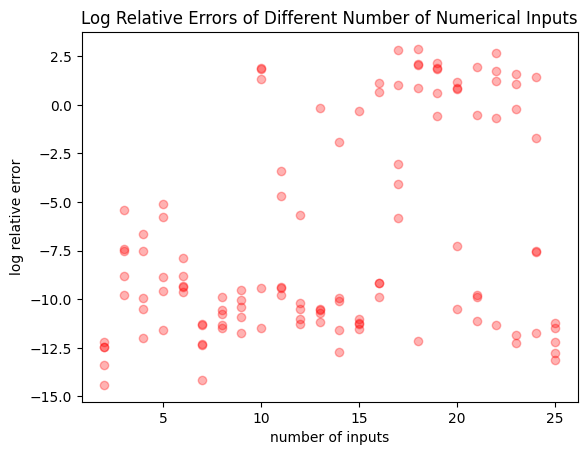

this plot is a little noisy since a random sample of inputs is chosen between numerical and categorical baseline set


In [ ]:
# plots errors
print(errors)
plt.plot(Nvars, torch.log(torch.tensor(errors)), 'ro', alpha=0.3) # *** need to fix indexes --> from 1 to nvars
# *** fix this to plot relative error at the end of the DLG process
plt.title('Log Relative Errors of Different Number of Numerical Inputs')
plt.xlabel('number of inputs')
plt.ylabel('log relative error')
plt.savefig('dlg_brazpd_ninputs-errors.png', dpi=300)
plt.show()
print('this plot is a little noisy since a random sample of inputs is chosen between numerical and categorical baseline set')

# DLG Evolution

In [ ]:
# results of training a model + dlg
net.apply(weights_init)
epochs = 1000
batch_size = 4
dlg_rate = 10
verbose = True
net, train_data, train_target, test_data, test_target, input_dim, output_dim, scaler = setup_net(inp_cnt_num = 9, inp_cnt_cat = 16)

losses, dlg_timestamps, AA_REs, AA_RRate, AA_cos_angles, CA_REs, CA_RRate, CA_cos_angles, grad_norms \
    = train_net_Adam_DLG(net, criterion, device, scaler, train_data, train_target, output_dim, batch_size, epochs, verbose, dlg_rate, \
                            gt_data_len = input_dim, gt_onehot_label_len = output_dim, epoch_mult=2000, w_decay=1e-12, scheduler_k = 0.01, leak_no_train = False)

test_net(net, test_data, test_target)

numerical variables: ['CenterSizenpatients' 'Age' 'Primaryrenaldisease' 'DaviesScore'
 'Familyincome' 'timeofpredialysiscare' 'Centerexperiencepatientyear'
 'BMI' 'Distancefromcenter']
[[128.        71.2       81.       ...  30.763889  20.7        1.      ]
 [128.        23.3        0.       ...  30.763889  28.3        1.      ]
 [128.        49.2       81.       ...  30.763889  31.5        1.      ]
 ...
 [ 66.        84.        50.       ...  16.416667  23.5        1.      ]
 [ 66.        54.2       50.       ...  16.416667  35.         1.      ]
 [ 66.        77.8       81.       ...  16.416667  20.6        3.      ]]
[[1]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
categorical variables: ['IncidentinPD' 'PrevalentinPDNet' 'PreviousHD' 'Previoustx'
 'Peripheralarterydisease' 'Cancer' 'Stroke' 'Hypertension' 'HIV' 'HCV'
 'HBC' 'Gender' 'Race' 'predialysiscare' 'Educationdic4y' 'Region']
[[1 0 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 ...
 [1 0 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 0 1 ...

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.5800e+02,  5.8000e+01,  0.0000e+00, -1.1102e-16,  2.0000e+00,
         0.0000e+00,  8.9438e+01,  2.6900e+01,  3.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 3.5709e+02,  5.8002e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 8.7000e+01,  5.6600e+01,  3.0000e+01, -1.1102e-16,  1.0000e+00,
         0.0000e+00,  2.2117e+01,  3.2300e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 4.9228e+01,  1.9945e+02,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.0300e+02, 6.9300e+01, 1.0000e+01, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        6.5958e+01, 2.7300e+01, 2.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64) tensor([ 3.1538e+02,  6.2005e+01,  8.0782e+01,  1.0235e+00,  1.8488e+00,
         7.9332e+01,  7.0206e+01,  1.

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 5.6000e+01,  8.1200e+01,  8.1000e+01,  1.0000e+00,  1.0000e+00,
         1.5000e+01,  1.4931e+01,  1.9600e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 2.3768e+02,  3.2205e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.5800e+02,  4.1600e+01,  3.0000e+01, -1.1102e-16,  2.0000e+00,
         7.0000e+00,  8.9438e+01,  2.1900e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-1.1892e+03, -2.4890e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 6.4000e+01,  5.4800e+01,  8.1000e+01,  1.0000e+00,  2.0000e+00,
         1.8000e+01,  1.9472e+01,  2.9500e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 6.5862e+02, -7.4219e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.0300e+02, 5.6500e+01, 8.1000e+01, 1.0000e+00, 2.0000e+00, 0.0000e+00,
        6.5958e+01, 2.8400e+01, 2.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64) tensor([ 3.2229e+02,  7.6676e+01,  6.6550e+01,  1.6751e+00,  2.1855e+00,
         4.3679e+01,  3.4825e+01,  2.

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.6900e+02,  5.8400e+01,  8.1000e+01,  1.0000e+00,  2.0000e+00,
         1.2000e+02,  4.2683e+01,  2.4900e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.6484e+02,  4.7228e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 9.3000e+01,  6.0100e+01,  8.1000e+01,  1.0000e+00,  2.0000e+00,
         2.4000e+01,  1.9867e+01,  2.7000e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.7868e+01,  4.4701e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 4.2000e+01,  5.1500e+01,  8.1000e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  7.5000e+00,  1.9900e+01,  3.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 8.8115e+01,  5.1235e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 9.8000e+01,  7.3100e+01,  8.1000e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  2.3708e+01,  2.1600e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-2.0689e+03,  9.5242e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.9700e+02,  9.3800e+01,  0.0000e+00, -1.1102e-16,  6.0000e+00,
         0.0000e+00,  5.4069e+01,  2.4696e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.2883e+03,  1.1297e+02,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 6.4000e+01,  4.7400e+01,  2.0000e+01, -1.1102e-16,  1.0000e+00,
         0.0000e+00,  1.5750e+01,  3.2300e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 5.9112e+01,  6.9245e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.2200e+02,  6.9700e+01,  0.0000e+00,  3.0000e+00,  2.0000e+00,
         0.0000e+00,  4.9292e+01,  2.1300e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 3.3933e+02,  3.9103e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.2400e+02,  6.0100e+01,  5.0000e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  2.4889e+01,  2.6300e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 9.9905e+01,  5.7148e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([1.1100e+02, 7.0700e+01, 1.0000e+01, 2.0000e+00, 2.0000e+00, 3.0000e+00,
        2.9983e+01, 2.0300e+01, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64) tensor([ 1.0457e+02,  7.7065e+01, -8.5086e+00,  1.7847e+00,  1.7305e+00,
        -3.3480e+00,  2.4581e+01,  2.

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([9.3000e+01, 6.3300e+01, 1.0000e+02, 1.0000e+00, 2.0000e+00, 0.0000e+00,
        2.7200e+01, 2.4000e+01, 2.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64) tensor([ 1.8038e+02,  6.2862e+01,  1.0675e+02,  9.3366e-01,  1.9691e+00,
         1.3917e+01,  5.9497e+01,  2.

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.2000e+02,  8.5600e+01,  1.0000e+02, -1.1102e-16,  2.0000e+00,
         1.2000e+01,  8.1972e+01,  2.9000e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-1.0615e+03,  1.1023e+02,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 7.5000e+01,  7.1900e+01,  8.1000e+01,  3.0000e+00,  1.0000e+00,
         3.0000e+01,  1.7967e+01,  2.2100e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 3.6550e+02,  9.2020e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 7.5000e+01,  3.9500e+01,  0.0000e+00, -1.1102e-16,  1.0000e+00,
         0.0000e+00,  1.7600e+01,  2.9900e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 7.7615e+01,  4.0315e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 9.8000e+01,  4.8200e+01,  8.1000e+01,  1.0000e+00,  2.0000e+00,
         0.0000e+00,  2.0792e+01,  2.6300e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.4333e+02,  4.3202e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 7.6000e+01,  6.6600e+01,  1.0000e+02, -1.1102e-16,  2.0000e+00,
         3.8000e+01,  1.5250e+01,  2.3200e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 6.0440e+01,  6.7493e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.6800e+02,  6.2600e+01,  0.0000e+00,  1.0000e+00,  2.0000e+00,
         0.0000e+00,  8.3083e+01,  1.9500e+01,  4.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-9.7923e+02,  5.5194e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 5.0000e+01,  8.2700e+01,  0.0000e+00,  1.0000e+00,  3.0000e+00,
         1.4000e+01,  1.2847e+01,  2.2100e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 4.5679e+01,  8.4795e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.6900e+02,  7.9000e+01,  1.0000e+02, -1.1102e-16,  3.0000e+00,
         6.0000e+01,  4.2683e+01,  3.2300e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-1.2222e+02,  7.3074e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.4300e+02,  5.0300e+01,  1.0000e+01, -1.1102e-16,  1.0000e+00,
         9.0000e+00,  2.9000e+01,  1.8700e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.4193e+02,  6.7933e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 4.8000e+01,  6.6400e+01,  8.1000e+01,  3.0000e+00,  3.0000e+00,
         4.8000e+01,  1.6472e+01,  2.3500e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 4.6326e+01,  6.6845e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 7.6000e+01,  6.5400e+01,  8.1000e+01,  1.0000e+00,  3.0000e+00,
         0.0000e+00,  1.5250e+01,  2.7700e+01,  3.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 6.4545e+01,  7.4388e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.0900e+02,  6.1100e+01,  8.1000e+01,  2.0000e+00,  1.0000e+00,
         2.4000e+01,  6.2361e+01,  3.2400e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 2.5598e+02,  5.6389e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.0900e+02,  9.3100e+01,  7.0000e+01,  1.0000e+00,  2.0000e+00,
         5.8000e+01,  6.2361e+01,  2.4600e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 2.2039e+02,  1.0099e+02,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.0300e+02, 6.8900e+01, 8.1000e+01, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        6.5958e+01, 1.9200e+01, 4.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64) tensor([ 4.1933e+02,  7.0165e+01,  5.1340e+01,  9.1734e-01,  1.2974e+00,
        -1.2070e+01,  8.2340e+01,  1.

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 6.6000e+01,  5.9400e+01,  8.1000e+01, -1.1102e-16,  1.0000e+00,
         1.8000e+01,  1.6417e+01,  3.1600e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 6.3058e+02, -3.7814e+00,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.6800e+02,  5.6500e+01,  0.0000e+00, -1.1102e-16,  2.0000e+00,
         0.0000e+00,  8.3083e+01,  2.4696e+01,  3.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-1.3407e+03,  4.7902e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 8.7000e+01,  6.5900e+01,  8.1000e+01,  3.0000e+00,  1.0000e+00,
         3.6000e+01,  2.2117e+01,  3.2100e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-2.4469e+02,  5.8734e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 6.5000e+01,  4.8900e+01,  1.0000e+02,  1.0000e+00,  2.0000e+00,
         1.2200e+02,  2.3167e+01,  2.4000e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 3.4952e+01,  4.1647e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 6.5000e+01,  4.1800e+01,  0.0000e+00, -1.1102e-16,  2.0000e+00,
         0.0000e+00,  2.3167e+01,  2.1300e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 3.4049e+02,  3.1584e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 7.6000e+01,  7.2400e+01,  8.1000e+01,  1.0000e+00,  2.0000e+00,
         4.0000e+01,  1.5250e+01,  2.0300e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-4.0705e+01,  7.8609e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.4300e+02,  4.3700e+01,  0.0000e+00, -1.1102e-16,  2.0000e+00,
         6.0000e+00,  2.9000e+01,  2.2100e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-9.0558e+00,  7.5728e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.9700e+02,  7.8000e+01,  0.0000e+00, -1.1102e-16,  6.0000e+00,
         0.0000e+00,  5.4069e+01,  2.4696e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 6.8979e+02,  5.8305e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.7000e+01,  6.3700e+01,  8.1000e+01,  2.0000e+00,  2.0000e+00,
         3.5000e+01,  8.8500e+00,  1.8400e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-9.0331e+01,  1.3983e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 9.3000e+01,  6.6900e+01,  8.1000e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.9867e+01,  1.9100e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.0713e+02,  5.5275e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.6700e+02,  7.9800e+01,  1.0000e+02,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  8.1625e+01,  1.6500e+01,  3.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-1.2087e+03,  7.0330e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.9000e+01,  4.9400e+01,  8.1000e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  8.4500e+00,  2.1200e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00, -1.1102e-16,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-7.2372e+00,  5.0939e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.9800e+02,  5.3000e+01,  3.0000e+01, -1.1102e-16,  2.0000e+00,
         1.8000e+01,  8.2958e+01,  2.9100e+01,  5.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 4.6971e+02, -1.1284e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.1200e+02,  5.0000e+01,  8.1000e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  2.7500e+01,  2.5200e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-5.7631e+02,  9.1039e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.0300e+02,  7.9900e+01,  8.1000e+01,  2.0000e+00,  1.0000e+00,
         2.0000e+00,  2.6950e+01,  3.5200e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.0150e+02,  7.1052e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.6800e+02,  6.5500e+01,  2.0000e+01,  1.0000e+00,  3.0000e+00,
         8.8000e+01,  8.3083e+01,  4.3400e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-6.4903e+02, -2.2662e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.9300e+02,  4.7800e+01,  3.0000e+01, -1.1102e-16,  2.0000e+00,
         3.6000e+01,  5.1944e+01,  2.7400e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 7.9371e+00,  2.0224e+02,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([1.4600e+02, 7.4500e+01, 8.1000e+01, 3.0000e+00, 2.0000e+00, 0.0000e+00,
        4.3900e+01, 2.5100e+01, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64) tensor([ 2.1367e+02,  9.0744e+01,  8.8891e+01,  2.7661e+00,  1.6702e+00,
         1.3858e+01,  3.2493e+01,  1.

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.4300e+02,  7.8300e+01,  8.1000e+01,  1.0000e+00,  2.0000e+00,
         1.1000e+01,  2.9000e+01,  2.3500e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 6.2529e+02,  1.3148e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 7.6000e+01,  5.0600e+01,  8.1000e+01,  1.0000e+00,  3.0000e+00,
         0.0000e+00,  1.5250e+01,  2.0600e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-1.1268e+01,  3.1725e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.0300e+02, 5.2200e+01, 1.0000e+02, 1.0000e+00, 2.0000e+00, 0.0000e+00,
        6.5958e+01, 2.6800e+01, 2.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64) tensor([ 4.2264e+02,  6.4284e+01,  9.5235e+01, -3.5155e-01,  2.3890e+00,
        -1.3750e+01,  6.1887e+01,  2.

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.9700e+02,  5.5200e+01,  0.0000e+00, -1.1102e-16,  3.0000e+00,
         0.0000e+00,  5.4069e+01,  2.4696e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 3.8632e+02,  7.1777e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.9700e+02,  6.5300e+01,  0.0000e+00, -1.1102e-16,  3.0000e+00,
         0.0000e+00,  5.4069e+01,  2.4696e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 2.0005e+02,  1.1402e+02,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.6800e+02,  5.2500e+01,  5.0000e+01, -1.1102e-16,  1.0000e+00,
         0.0000e+00,  8.3083e+01,  2.1600e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-6.5776e+02,  1.5214e+02,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.8900e+02,  6.5900e+01,  8.1000e+01,  1.0000e+00,  1.0000e+00,
         3.0000e+01,  2.3458e+01,  2.2800e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.9547e+02,  5.8942e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.4300e+02,  6.5600e+01,  0.0000e+00, -1.1102e-16,  1.0000e+00,
         4.0000e+00,  2.9000e+01,  2.2800e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.3747e+02,  1.0826e+02,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.2500e+02,  6.3300e+01,  8.1000e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  3.2167e+01,  2.5100e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 4.5727e+02, -2.4288e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 8.7000e+01,  4.0000e+01,  1.0000e+02,  1.0000e+00, -2.2204e-16,
         0.0000e+00,  2.2117e+01,  1.9800e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00, -1.1102e-16,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 2.3341e+02,  1.5729e+02,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 8.9000e+01,  7.1900e+01,  8.1000e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  2.5867e+01,  2.4100e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 4.3598e+01,  7.6044e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.9800e+02,  7.4000e+01,  5.0000e+01,  2.0000e+00,  2.0000e+00,
         2.0000e+00,  8.2958e+01,  2.4800e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 4.3253e+02,  7.1284e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.5800e+02,  4.5100e+01,  1.0000e+02, -1.1102e-16,  1.0000e+00,
         0.0000e+00,  8.9438e+01,  2.3800e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-2.8947e+03,  7.7733e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.1200e+02,  5.5900e+01,  3.0000e+01,  1.0000e+00,  2.0000e+00,
         0.0000e+00,  2.7500e+01,  2.5100e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 2.1521e+02,  7.1522e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.4600e+02,  5.3600e+01,  5.0000e+01, -1.1102e-16,  1.0000e+00,
         0.0000e+00,  4.3900e+01,  2.4300e+01,  3.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-5.0607e+02,  7.1077e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 4.3000e+01,  7.2200e+01,  8.1000e+01,  3.0000e+00,  3.0000e+00,
         1.2600e+02,  7.0278e+00,  1.9000e+01,  4.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 9.8693e+01,  7.5376e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([3.5800e+02, 6.3200e+01, 8.1000e+01, 1.0000e+00, 3.0000e+00, 0.0000e+00,
        8.9438e+01, 2.3500e+01, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64) tensor([-1.3989e+03, -4.2388e+00, -8.5758e+01, -4.8562e+00,  5.5581e+00,
        -3.0017e+01,  2.8360e+02,  4.

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 6.0000e+01,  6.1700e+01,  8.1000e+01,  1.0000e+00,  1.0000e+00,
         3.0000e+01,  8.9333e+00,  2.7700e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-4.8447e+01,  8.5377e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.2200e+02,  6.9700e+01,  0.0000e+00,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  4.9292e+01,  2.1600e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 3.8830e+02,  7.5070e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 7.4000e+01,  8.1400e+01,  1.0000e+02, -1.1102e-16,  1.0000e+00,
         0.0000e+00,  1.4556e+01,  2.0800e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 2.4565e+02,  1.1946e+02,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.9000e+01,  5.3600e+01,  8.1000e+01,  1.0000e+00,  1.0000e+00,
         6.0000e+00,  8.4500e+00,  2.1000e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-3.9209e+02,  6.8202e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.0900e+02,  8.1300e+01,  8.1000e+01,  2.0000e+00,  2.0000e+00,
         5.0000e+00,  6.2361e+01,  1.9600e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00, -1.1102e-16,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-1.3418e+02, -4.8858e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 9.3000e+01,  7.3200e+01,  8.1000e+01,  1.0000e+00,  2.0000e+00,
         3.6000e+01,  1.9867e+01,  2.3200e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 6.2165e+02,  1.1729e+02,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([1.9300e+02, 6.6300e+01, 8.1000e+01, 1.0000e+00, 2.0000e+00, 0.0000e+00,
        5.1944e+01, 2.0000e+01, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64) tensor([ 2.4926e+02,  1.6081e+02,  2.2110e+02,  5.5896e+00,  4.2075e+00,
        -1.3780e+02,  1.1618e+02, -3.

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.2200e+02,  7.4600e+01,  0.0000e+00, -1.1102e-16,  1.0000e+00,
         0.0000e+00,  4.9292e+01,  1.7900e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 6.9593e+02,  9.7336e+00,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 6.6000e+01,  3.1800e+01,  1.0000e+02, -1.1102e-16,  1.0000e+00,
         2.4000e+01,  1.6417e+01,  2.2000e+01,  3.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 3.7149e+01,  7.0455e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.0200e+02,  7.1800e+01,  8.1000e+01,  2.0000e+00,  2.0000e+00,
         6.4000e+01,  2.9236e+01,  2.1100e+01,  4.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 8.8365e+01,  7.3421e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 9.8000e+01,  6.3200e+01,  5.0000e+01, -1.1102e-16,  1.0000e+00,
         0.0000e+00,  2.0792e+01,  1.3900e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 2.6025e+02,  1.1188e+02,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 8.1000e+01,  7.0500e+01,  8.1000e+01,  1.0000e+00,  1.0000e+00,
         6.0000e+00,  2.7117e+01,  1.8300e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 2.7272e+00,  1.0560e+02,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.5800e+02,  5.9000e+01,  1.0000e+02, -1.1102e-16,  1.0000e+00,
         0.0000e+00,  8.9438e+01,  2.1800e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 5.3155e+02,  1.2026e+02,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.2000e+01, 6.3600e+01, 1.0000e+02, 2.0000e+00, 2.0000e+00, 0.0000e+00,
        9.6458e+00, 2.1200e+01, 3.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64) tensor([-1.1385e+02, -4.4642e+01,  1.5915e+02,  4.5569e+00, -5.2006e+00,
         4.6787e+01, -4.0317e+01,  2.

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.3100e+02,  3.7200e+01,  1.0000e+02, -1.1102e-16,  1.0000e+00,
         9.4000e+01,  4.3479e+01,  2.2300e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([69.3260, 58.7693, 94.9299

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.0300e+02,  7.0900e+01,  8.1000e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  2.6950e+01,  2.5600e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 9.1631e+01,  7.8348e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.9800e+02,  2.1700e+01,  0.0000e+00, -1.1102e-16,  2.0000e+00,
         2.0000e+00,  8.2958e+01,  1.7900e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 5.2883e+02,  9.4319e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 4.1000e+01,  6.4300e+01,  8.1000e+01,  2.0000e+00,  2.0000e+00,
         0.0000e+00,  9.2292e+00,  1.9100e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 7.0329e+01,  8.2553e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.2400e+02,  4.6200e+01,  1.0000e+01, -1.1102e-16,  4.0000e+00,
         2.4000e+01,  3.4681e+01,  3.3300e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.4158e+02,  7.7535e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.4300e+02,  5.9800e+01,  5.0000e+01,  2.0000e+00,  2.0000e+00,
         0.0000e+00,  2.9000e+01,  2.8100e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.0212e+02,  7.2466e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.0900e+02,  6.9300e+01,  8.1000e+01,  1.0000e+00,  2.0000e+00,
         0.0000e+00,  6.2361e+01,  2.6300e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 7.0157e+02,  1.5476e+02,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 5.0000e+01,  3.9200e+01,  1.3000e+01,  1.0000e+00,  2.0000e+00,
         4.8000e+01,  1.1733e+01,  2.9500e+01,  4.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-8.4064e+01,  3.5691e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.0300e+02,  6.2100e+01,  1.0000e+01,  1.0000e+00,  2.0000e+00,
         1.2000e+02,  2.6950e+01,  2.4500e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-1.0592e+02,  7.3744e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 9.3000e+01,  6.5300e+01,  8.1000e+01,  3.0000e+00,  2.0000e+00,
         2.4000e+01,  1.9867e+01,  2.2500e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 2.8995e+02,  6.8589e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.0300e+02, 7.5200e+01, 8.1000e+01, 1.0000e+00, 2.0000e+00, 0.0000e+00,
        6.5958e+01, 2.8700e+01, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64) tensor([ 3.9429e+02,  8.0779e+01,  9.2993e+01,  1.2613e+00,  2.7959e+00,
         2.7175e+01,  6.6259e+01,  2.

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 8.7000e+01,  5.1300e+01,  8.1000e+01,  1.0000e+00,  2.0000e+00,
         6.0000e+01,  2.2117e+01,  2.6800e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.1714e+01,  1.2245e+02,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.3100e+02,  7.1300e+01,  0.0000e+00, -1.1102e-16,  3.0000e+00,
         0.0000e+00,  4.3479e+01,  2.7000e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 2.5070e+02,  8.2483e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.0000e+02,  6.5600e+01,  8.1000e+01,  1.0000e+00,  2.0000e+00,
         1.4000e+01,  4.8681e+01,  2.1400e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 3.7343e+02,  1.0980e+02,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 5.1000e+01,  7.1500e+01,  0.0000e+00,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  8.5667e+00,  2.9900e+01,  4.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-3.9012e+02, -1.6111e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.1200e+02,  3.0600e+01,  8.1000e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  2.7500e+01,  2.0900e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.0841e+02,  3.3555e+01,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.0400e+02,  6.2700e+01,  5.0000e+01,  1.0000e+00,  3.0000e+00,
         1.4000e+01,  3.7333e+01,  2.4200e+01,  3.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00, -1.1102e-16,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 4.5774e+02,  1.4002e+02,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.2000e+02,  6.4800e+01,  1.0000e+02, -1.1102e-16,  1.0000e+00,
         4.0000e+00,  8.1972e+01,  2.5800e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 6.7696e+02,  1.6054e+02,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 4.0300e+02,  8.8800e+01,  0.0000e+00, -1.1102e-16,  1.0000e+00,
         0.0000e+00,  6.5958e+01,  1.7500e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-5.4973e+02, -4.0544e+00,

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 4.0300e+02,  5.0200e+01,  1.0000e+02, -1.1102e-16,  2.0000e+00,
         0.0000e+00,  6.5958e+01,  1.9000e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 7.3660e+02,  1.3503e+02,

In [ ]:
# save python results for future reference
import pickle
save_file = 'train_brazpd_*_dlg-l.p'
path = 'drive/MyDrive/UROP/Project Files/'
drive_file = path + save_file
print(save_file, drive_file)

from google.colab import drive
pickle.dump((epochs, losses, dlg_timestamps, AA_REs, AA_RRate, AA_cos_angles, CA_REs, CA_RRate, CA_cos_angles, grad_norms), open(save_file, "wb"))
drive.mount('/content/drive/')
!cp "$save_file" "$drive_file"  # need double quotations since path has a space
drive.flush_and_unmount()

train_brazpd_4_dlg-l.p drive/MyDrive/UROP/Project Files/train_brazpd_4_dlg-l.p
Mounted at /content/drive/


In [ ]:
# load python results
import pickle
save_file = 'train_brazpd_1_dlg-l.p'
path = 'drive/MyDrive/UROP/Project Files/'
drive_file = path + save_file

from google.colab import drive
drive.mount('/content/drive/')
!cp "$drive_file" "$save_file"  # need double quotations since path has a space
drive.flush_and_unmount()
epochs, losses, dlg_timestamps, AA_REs, AA_RRate, AA_cos_angles, CA_REs, CA_RRate, CA_cos_angles, grad_norms = pickle.load(open(save_file, "rb"))

Mounted at /content/drive/


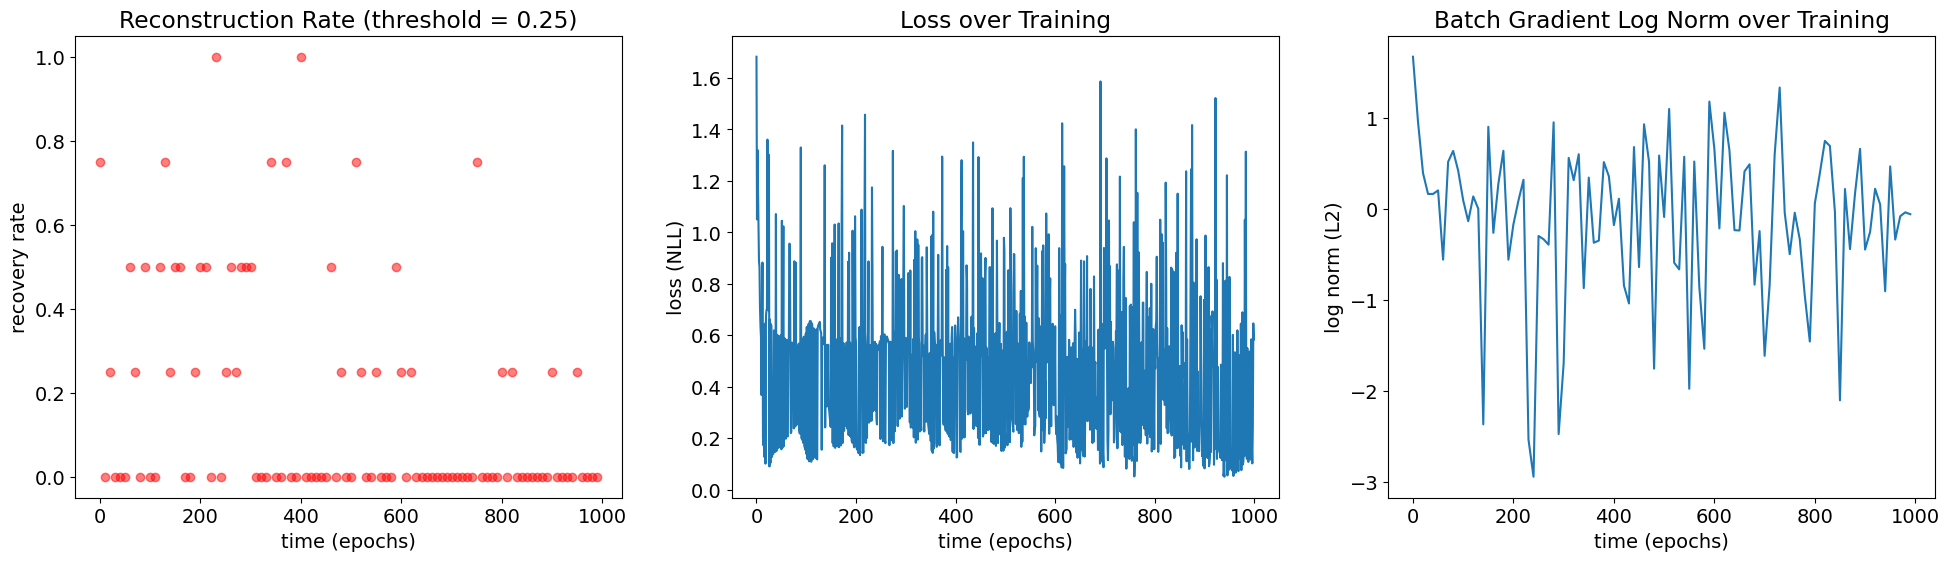

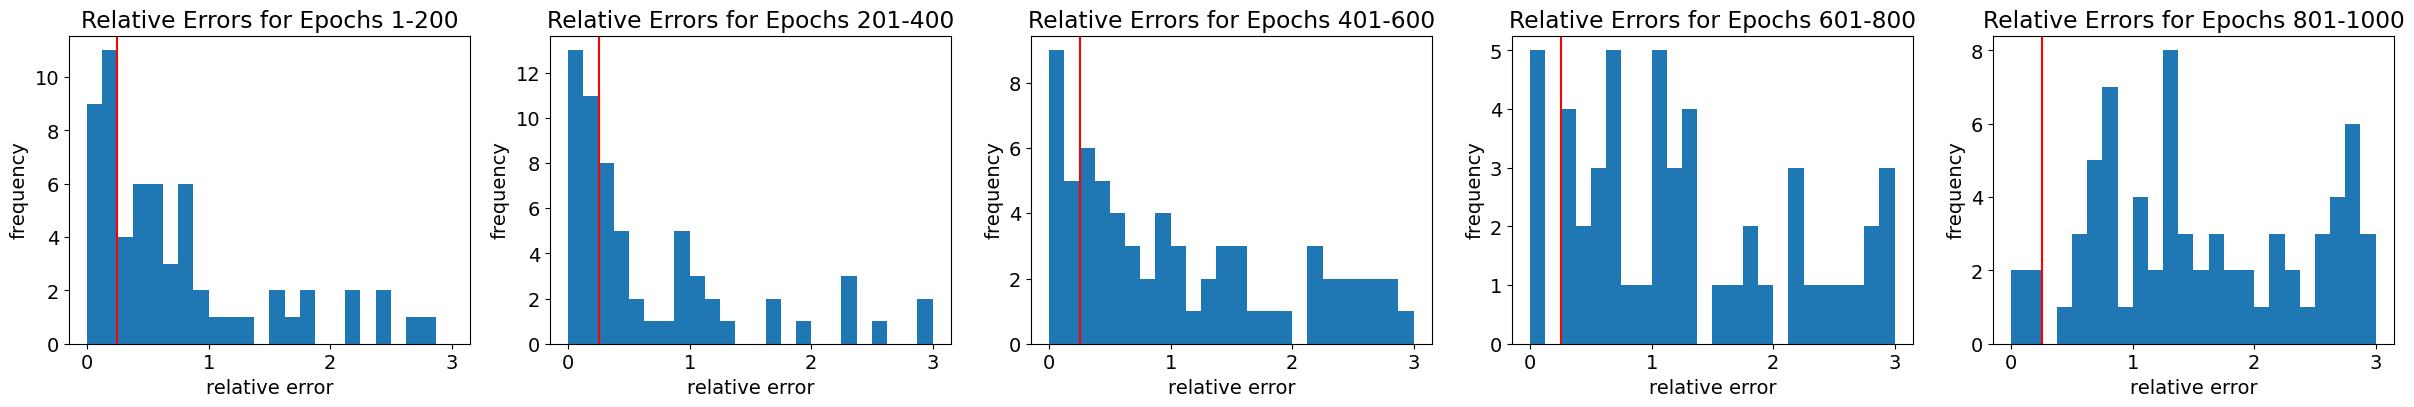

Note that in the histogram plots, a few outliers with much greater relative errors were ignored in favor of the majority of the data points
This is for the complete assignment
the red line indicates the reconstruction rate threshold


In [ ]:
#@title summary plots for complete assignment (reconstruction rate, loss, batch gradient norm, relative errors)
rows = 1; cols = 3
fig, axs = plt.subplots(rows, cols, figsize=(8*cols, 6*rows))

# make text visible
plt.rcParams.update({'font.size': 14})

# dlg summary
axs[0].plot(dlg_timestamps, AA_RRate, 'ro', alpha=0.5)
axs[0].set(title='Reconstruction Rate (threshold = 0.25)', xlabel='time (epochs)', ylabel='recovery rate')

axs[1].plot(list(range(epochs)), losses)
axs[1].set(title='Loss over Training', xlabel='time (epochs)', ylabel='loss (NLL)')

axs[2].plot(dlg_timestamps, torch.log(torch.tensor(grad_norms)))
axs[2].set(title='Batch Gradient Log Norm over Training', xlabel='time (epochs)', ylabel='log norm (L2)')

plt.savefig('train_brazpd_4_big_summary.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

# relative errors histogram plot
cnt = 20 # *** note that this must divide the number of dlg samples
dlg_rate = dlg_timestamps[1] - dlg_timestamps[0]
group_size = cnt*dlg_rate
batch_AA_REs = [torch.flatten(torch.tensor(AA_REs[i:i+cnt])).numpy() for i in range(0, len(AA_RRate), cnt)]
rows2 = 1; cols2 = 5
fig2, axs2 = plt.subplots(rows2, cols2, figsize=(6*cols2, 4*rows2))

for i in range(5):
    axs2[i].hist(batch_AA_REs[i], bins=24, range=[0, 3])
    axs2[i].set(title=f'Relative Errors for Epochs {group_size*i + 1}-{group_size*(i+1)}', xlabel='relative error', ylabel='frequency')
    axs2[i].axvline(0.25, color='red')

plt.savefig('train_brazpd_4_big_AARE_hist.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

print('Note that in the histogram plots, a few outliers with much greater relative errors were ignored in favor of the majority of the data points')
print('This is for the complete assignment')
print('the red line indicates the reconstruction rate threshold')

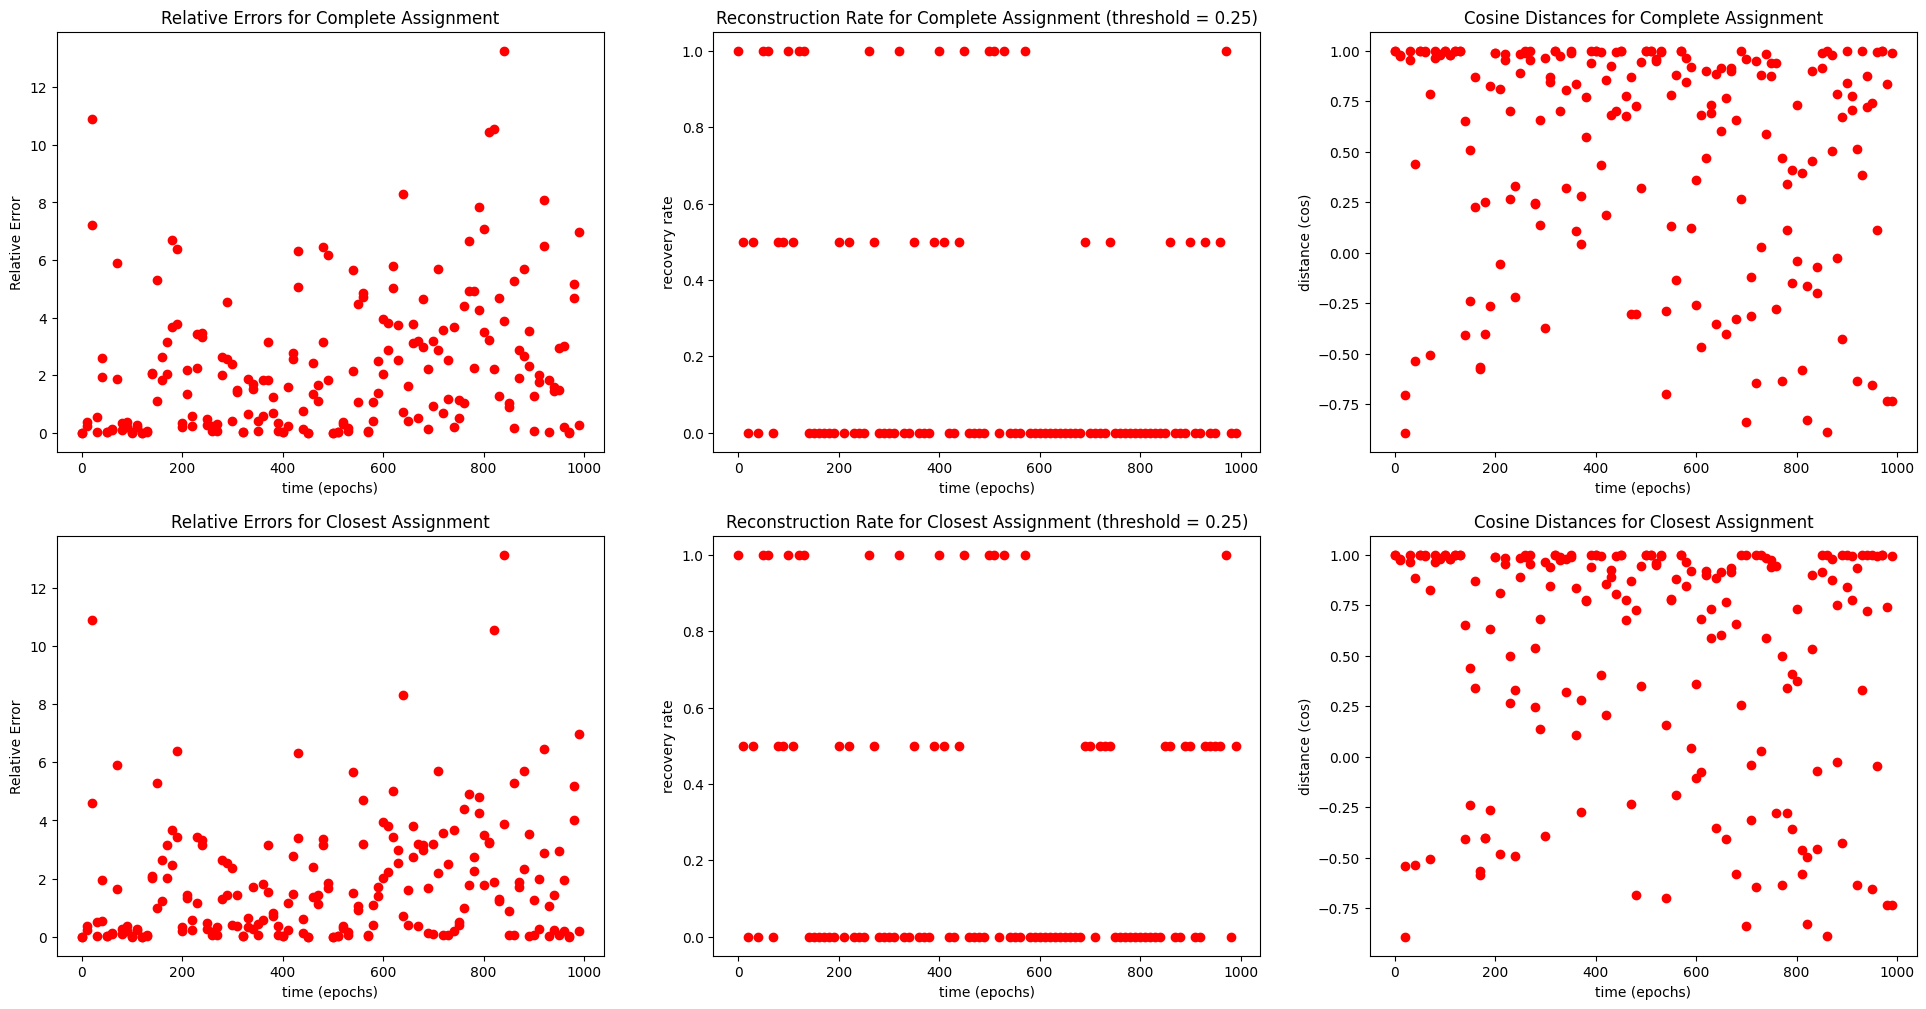

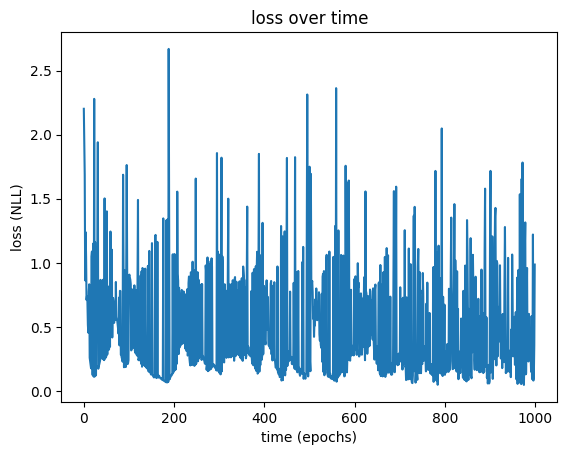

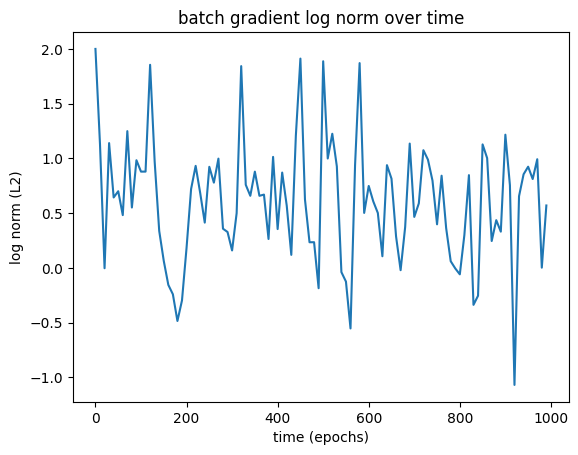

In [ ]:
#@title create summary plots comparing both assignment methods (relative error, cosine distance, reconstruction rate, loss, batch gradient norm)
fig, axs = plt.subplots(2, 3, figsize=(8*3, 6*2))

# complete assignment
axs[0, 0].plot(dlg_timestamps, AA_REs, 'ro')
axs[0, 0].set(title='Relative Errors for Complete Assignment', xlabel='time (epochs)', ylabel='Relative Error')

axs[0, 1].plot(dlg_timestamps, AA_RRate, 'ro')
axs[0, 1].set(title='Reconstruction Rate for Complete Assignment (threshold = 0.25)', xlabel='time (epochs)', ylabel='recovery rate')

axs[0, 2].plot(dlg_timestamps, AA_cos_angles, 'ro')
axs[0, 2].set(title='Cosine Distances for Complete Assignment', xlabel='time (epochs)', ylabel='distance (cos)')

# closest assignment
axs[1, 0].plot(dlg_timestamps, CA_REs, 'ro')
axs[1, 0].set(title='Relative Errors for Closest Assignment', xlabel='time (epochs)', ylabel='Relative Error')

axs[1, 1].plot(dlg_timestamps, CA_RRate, 'ro')
axs[1, 1].set(title='Reconstruction Rate for Closest Assignment (threshold = 0.25)', xlabel='time (epochs)', ylabel='recovery rate')

axs[1, 2].plot(dlg_timestamps, CA_cos_angles, 'ro')
axs[1, 2].set(title='Cosine Distances for Closest Assignment', xlabel='time (epochs)', ylabel='distance (cos)')

plt.savefig('train_BRAZPD_1-r.png', dpi=300)
plt.show()

plt.plot(list(range(epochs)), losses)
plt.title('loss over time')
plt.xlabel('time (epochs)')
plt.ylabel('loss (NLL)')
plt.savefig('train_BRAZPD_1_loss-r.png', dpi=300)
plt.show()

plt.plot(dlg_timestamps, torch.log(torch.tensor(grad_norms)))
plt.title('batch gradient log norm over time')
plt.xlabel('time (epochs)')
plt.ylabel('log norm (L2)')
plt.savefig('train_BRAZPD_1_norm-r.png', dpi=300)
plt.show()

In [ ]:
#@title Evolution Plots (not updated)
# evolution of SEs, normalized errors, cosine distances
fig, axs = plt.subplots(len(dlg_timestamps), 3, sharex='col', figsize=(24, len(dlg_timestamps)*4))

for i in range(len(dlg_timestamps)):
    axs[i, 0].hist(torch.log(torch.tensor(dlg_SEs[i])), 50)
    axs[i, 0].set(title=f'log SE of batch DLG at epoch {dlg_timestamps[i]}', xlabel='log SE', ylabel='frequency')

    axs[i, 1].hist(torch.log(torch.tensor(dlg_n_errors[i])), 50)
    axs[i, 1].set(title=f'log NE of batch DLG at epoch {dlg_timestamps[i]}', xlabel='log NE', ylabel='frequency')

    axs[i, 2].hist(dlg_cos_angles[i], 50)
    axs[i, 2].set(title=f'cosine distances of batch DLG at epoch {dlg_timestamps[i]}', xlabel='cosine distance', ylabel='frequency')

# Notes

In [ ]:
# Todo

# future tasks -----------------------------------------------------------
# possibly modify single batch DLG rather than having to run DLG Evolution (debugging purposes --> can already simulate on DLG evolution epochs=1)
# also add comments to functions abstracted out into a package
# look at dp
# look at papers more related to FL
# estimate how quickly the model can be trained + attacked
# icml workshop for results
# consider other medical dataset
# possible idea - PCA with image tasks to capture similarity between reconstructed and true input data
# consider dropout with a probability like ~ 0.20-0.25 (or even, aggressively, 0.5 - good for generalization)